In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import statements:
import sys
import os
import yaml
sys.path.append(os.getcwd() + '/../Client_modules/')

from mTempControl import *
import mResSweepDouble
from socProxy import makeProxy
import h5py
from PythonDrivers.control_atten import setatten
from PythonDrivers.getInputDicts import *
import time
import datetime
from run_FFS import run_FFS
from PythonDrivers.ldausbcli import CLI_Vaunix_Attn
from contextlib import contextmanager,redirect_stderr,redirect_stdout
from os import devnull

# tempPath = os.path.join('Z:','t1Team','logFiles')

Could not import QickSoc: No module named 'pynq'


In [3]:
# Temperature monitoring infrastructure (this could be a module)
tc = tempController() # needs to be reinstantiated to read in latest day's logfile

In [4]:
# Instantiate four instances of the RFSOC
socs=[]
soccfgs=[]

soc1,soccfg1=makeProxy('192.168.1.10')
socs.append(soc1)
soccfgs.append(soccfg1)
print(soccfg1)

soc2,soccfg2=makeProxy('192.168.1.11')
socs.append(soc2)
soccfgs.append(soccfg2)
print(soccfg2)

soc3,soccfg3=makeProxy('192.168.1.12')
socs.append(soc3)
soccfgs.append(soccfg3)
print(soccfg3)

soc4,soccfg4=makeProxy('192.168.1.13')
socs.append(soc4)
soccfgs.append(soccfg4)
print(soccfg4)

Pyro.NameServer PYRO:Pyro.NameServer@192.168.1.10:8888
myqick PYRO:obj_cc11914ba620493495114f1c57aa6f33@192.168.1.10:34457

QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v4 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	1:	axis_signal_gen_v4 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	2:	axis_signal_gen_v4 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	3:	axis_signal_gen_v4 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	4:	axis_signal_gen_v4 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v4 - tProc output 6, envelope 

# Read in sweep parameters

In [5]:
# Read in sweep initial confirguration from yaml file
setup_file_name='2023-08-29_cooldown_setup.yaml'
setup_file_location = os.path.join('setup_files',setup_file_name)

stream = open(setup_file_location, 'r')
setupDict = yaml.full_load(stream)
stream.close()

# create and add wanted chipDicts, add a chip for each rfsoc
chipDicts=[]
chipDict1 = setupDict['2023-08-01 TALE04-annealed']
chipDict2 = setupDict['2023-08-21 TAHP02_AuPd_Cl_etch']
chipDict3 = setupDict['2023-08-24_TAHP02-Au-Cl-etch']
chipDict4 = setupDict['2023-08-24_TAHP02_Au_F_etch']



chipDicts.append(chipDict1)
chipDicts.append(chipDict2)
chipDicts.append(chipDict3)
chipDicts.append(chipDict4)

In [ ]:
....................................................

In [ ]:
tc.changeHeaterCurrentPercent(0)

In [7]:
tc.setTemp(0)

# Set attenuations and check that we using a good power

In [ ]:
savePath = r'Z:\t1Team\Data\rfsoc_dump'
attobj = CLI_Vaunix_Attn()
attobj.set_attenuation(1,20,1)
attobj.set_attenuation(1,20,2)
attobj.set_attenuation(1,10,3)
attobj.set_attenuation(1,10,4)

In [ ]:
getInputDicts(chipDict1,measType='FFS')[0]

In [ ]:
#RFSoC 10

# define sweep params
inputDict = {}
inputDict['LO_f'] = 0  # local oscillator frequency

# define frequencies
inputDict['span_f'] = [.01, .01]

# center freqs

#inputDict['res_f']=[4528.043,4776.834]
#inputDict['names']=['4p42',
#  '4p70']

inputDict['res_f']=[4935.091,5092.406]
inputDict['names']=['4p94',
  '5p09']

# define numbers of points
inputDict['n_expts'] = 500  # number of points along the frequency axis
inputDict['n_rounds'] = 1 # number of times to sweep along the frequency axis
inputDict['n_reps'] = 1  # number of repetitions to take at each frequency point
# inputDict['n_reps'] = 1

# timing. Units are clock cycles, but converted from us
inputDict['ring_up_time'] = 500  # time waiting for the resonator to ring up at the start of each sweep
inputDict['ring_between_time'] = 50  # time waiting for the resonator to ring up at the start of each sweep
inputDict['readout_length'] = 10000  # time to average over
inputDict['adc_trig_offset'] = 0.1  # time after the DAC starts the final steady pulse before the ADC starts it's read

# power
# idxs = [np.argmin(np.abs(np.array(f)-inputDict['res_f'][0])),np.argmin(np.abs(np.array(f)-inputDict['res_f'][1]))]
inputDict['basePowers'] = 0 # dBm
inputDict['gain'] = [30000, 30000]

# acquire data
# Acquire
inputDict['power'] = inputDict['basePowers']


Instance2 = mResSweepDouble.ResSweep(path=savePath, prefix='phase_test', inputDict=inputDict, soc=socs[0], soccfg=soccfgs[0])

with open(devnull,'w') as f:
    with redirect_stderr(f):
        data2 = mResSweepDouble.ResSweep.acquire(Instance2)
mResSweepDouble.ResSweep.display(Instance2, data2, fit=True)
# mResSweepDouble.ResSweep.save_data(Instance2, data2)

In [ ]:
# RFSoC 11

# define sweep params
inputDict = {}
inputDict['LO_f'] = 0  # local oscillator frequency

# define frequencies
inputDict['span_f'] = [.5, .5]

# center freqs

inputDict['res_f']=[7991.71,7385.58]
inputDict['names']=['4p42','4p70']
# define numbers of points
inputDict['n_expts'] = 500  # number of points along the frequency axis
inputDict['n_rounds'] = 1 # number of times to sweep along the frequency axis
inputDict['n_reps'] = 1  # number of repetitions to take at each frequency point

# timing. Units are clock cycles, but converted from us
inputDict['ring_up_time'] = 500  # time waiting for the resonator to ring up at the start of each sweep
inputDict['ring_between_time'] = 50  # time waiting for the resonator to ring up at the start of each sweep
inputDict['readout_length'] = 10000  # time to average over
inputDict['adc_trig_offset'] = 0.1  # time after the DAC starts the final steady pulse before the ADC starts it's read

# power
# idxs = [np.argmin(np.abs(np.array(f)-inputDict['res_f'][0])),np.argmin(np.abs(np.array(f)-inputDict['res_f'][1]))]
inputDict['basePowers'] = 0 # dBm
inputDict['gain'] = [30000, 30000]

# acquire data
# Acquire
inputDict['power'] = inputDict['basePowers']
Instance2 = mResSweepDouble.ResSweep(path=savePath, prefix='phase_test', inputDict=inputDict, soc=socs[1], soccfg=soccfgs[1])

with open(devnull,'w') as f:
    with redirect_stderr(f):
        data2 = mResSweepDouble.ResSweep.acquire(Instance2)
mResSweepDouble.ResSweep.display(Instance2, data2, fit=False)
# mResSweepDouble.ResSweep.save_data(Instance2, data2)

In [ ]:
# RFSoC 12

# define sweep params
inputDict = {}
inputDict['LO_f'] = 0  # local oscillator frequency

# define frequencies
inputDict['span_f'] = [1, 1]

# center freqs

inputDict['res_f']=[5957.693,6262.483]
inputDict['names']=['4p42',
  '4p70']
# define numbers of points
inputDict['n_expts'] = 5000  # number of points along the frequency axis
inputDict['n_rounds'] = 3 # number of times to sweep along the frequency axis
inputDict['n_reps'] = 1  # number of repetitions to take at each frequency point
# inputDict['n_reps'] = 1

# timing. Units are clock cycles, but converted from us
inputDict['ring_up_time'] = 500  # time waiting for the resonator to ring up at the start of each sweep
inputDict['ring_between_time'] = 50  # time waiting for the resonator to ring up at the start of each sweep
inputDict['readout_length'] = 10000  # time to average over
inputDict['adc_trig_offset'] = 0.1  # time after the DAC starts the final steady pulse before the ADC starts it's read

# power
# idxs = [np.argmin(np.abs(np.array(f)-inputDict['res_f'][0])),np.argmin(np.abs(np.array(f)-inputDict['res_f'][1]))]
inputDict['basePowers'] = 0 # dBm
inputDict['gain'] = [30000, 30000]

# acquire data
# Acquire
inputDict['power'] = inputDict['basePowers']
Instance2 = mResSweepDouble.ResSweep(path=savePath, prefix='phase_test', inputDict=inputDict, soc=socs[2], soccfg=soccfgs[2])

with open(devnull,'w') as f:
    with redirect_stderr(f):
        data2 = mResSweepDouble.ResSweep.acquire(Instance2)
mResSweepDouble.ResSweep.display(Instance2, data2, fit=False)
# mResSweepDouble.ResSweep.save_data(Instance2, data2)

In [ ]:
# RFSoC 13

# define sweep params
inputDict = {}
inputDict['LO_f'] = 0  # local oscillator frequency

# define frequencies
inputDict['span_f'] = [.5, .5]

# center freqs

inputDict['res_f']=[8014.64,8014.64]
inputDict['names']=['4p42',
  '4p70']
# define numbers of points
inputDict['n_expts'] = 500  # number of points along the frequency axis
inputDict['n_rounds'] = 1 # number of times to sweep along the frequency axis
inputDict['n_reps'] = 1  # number of repetitions to take at each frequency point
# inputDict['n_reps'] = 1

# timing. Units are clock cycles, but converted from us
inputDict['ring_up_time'] = 500  # time waiting for the resonator to ring up at the start of each sweep
inputDict['ring_between_time'] = 50  # time waiting for the resonator to ring up at the start of each sweep
inputDict['readout_length'] = 10000  # time to average over
inputDict['adc_trig_offset'] = 0.1  # time after the DAC starts the final steady pulse before the ADC starts it's read

# power
# idxs = [np.argmin(np.abs(np.array(f)-inputDict['res_f'][0])),np.argmin(np.abs(np.array(f)-inputDict['res_f'][1]))]
inputDict['basePowers'] = 0 # dBm
inputDict['gain'] = [30000, 30000]

# acquire data
# Acquire
inputDict['power'] = inputDict['basePowers']
Instance2 = mResSweepDouble.ResSweep(path=savePath, prefix='phase_test', inputDict=inputDict, soc=socs[3], soccfg=soccfgs[3])

with open(devnull,'w') as f:
    with redirect_stderr(f):
        data2 = mResSweepDouble.ResSweep.acquire(Instance2)
mResSweepDouble.ResSweep.display(Instance2, data2, fit=True)
# mResSweepDouble.ResSweep.save_data(Instance2, data2)

In [ ]:
temps=np.arange(0.030,0.290,0.020)
print(temps)

In [ ]:
temps=np.arange(0.170,0.270,0.020)
print(temps)

# Take measurements

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Frequencies out are: [4528.043, 4776.834] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.599 s


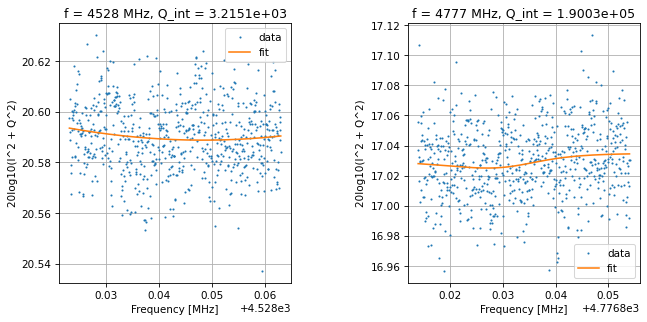

Frequencies out are: [4530.638828413391, 4776.832065334135] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 311.052 s


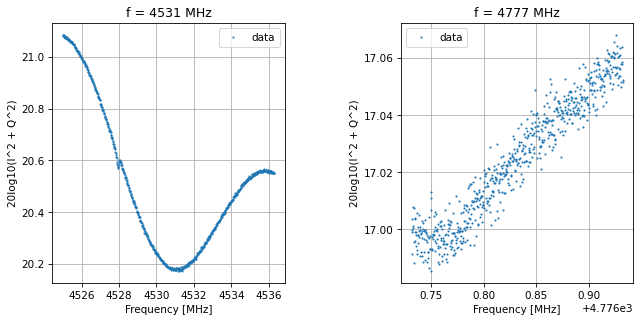

Saving data-2023-09-24-22-11-06
Frequencies out are: [4935.091, 5092.406] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.388 s


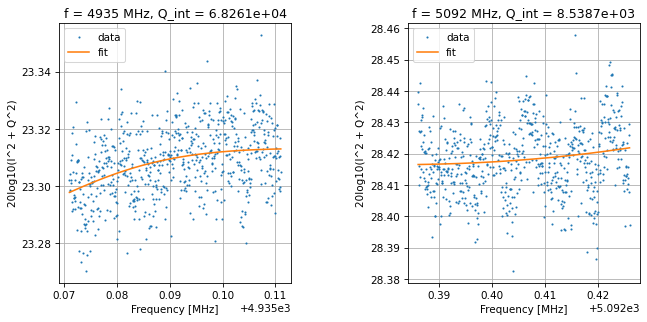

Frequencies out are: [4935.064646015446, 5092.6286382807675] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 311.174 s


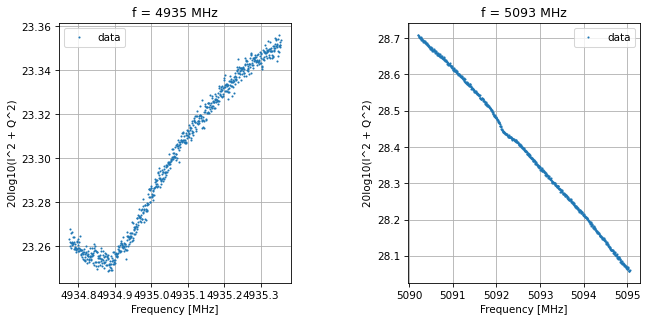

Saving data-2023-09-24-22-16-34
Frequencies out are: [5957.693, 6262.483] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.500 s


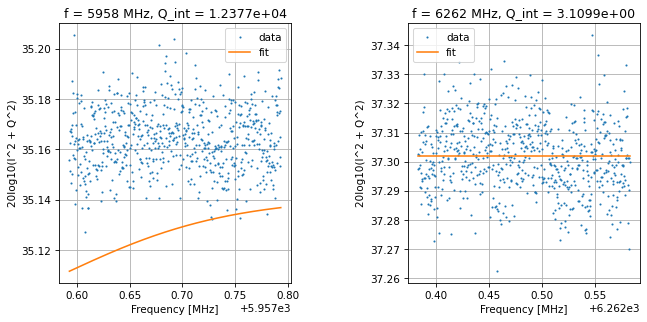

Frequencies out are: [5957.546833430078, 6262.844414544189] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 310.051 s


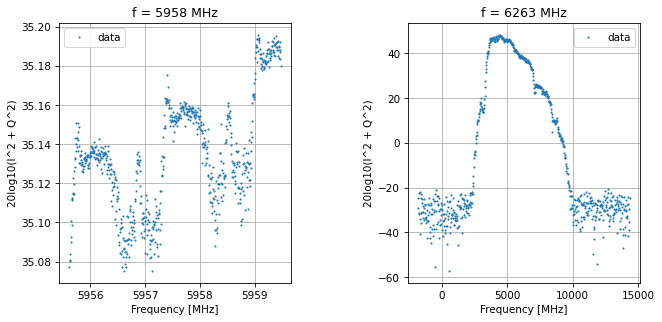

Saving data-2023-09-24-22-22-07
Frequencies out are: [6525.91, 6821.77] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.554 s


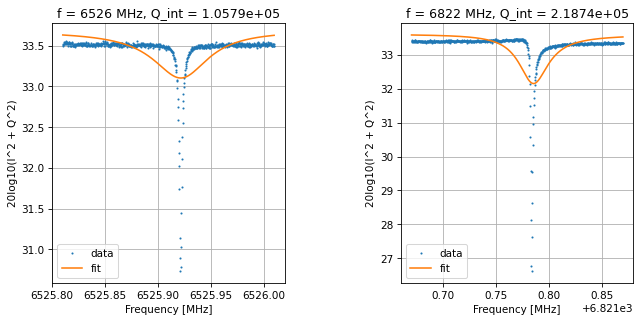

Frequencies out are: [6525.922735757049, 6821.7848238432925] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 310.028 s


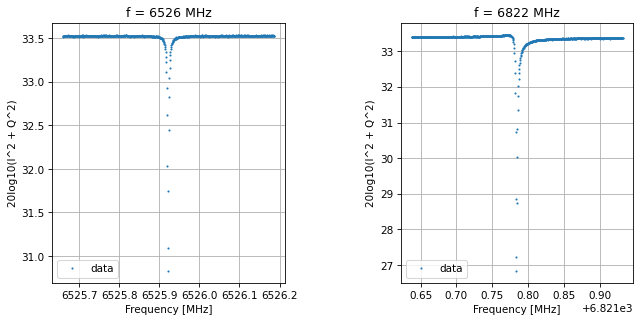

Saving data-2023-09-24-22-27-34
Frequencies out are: [7200.6, 7385.58] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.373 s
Failed to fit trace, skipping this resonator:
Z:t1Team\Data\2023-08-24_Cooldown\2023-08-24_TAHP02_AuPd_Cl_etch\freq_shift_rfsoc2 ['7p20', '7p38']
Frequencies out are: [7991.71] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 12.871 s


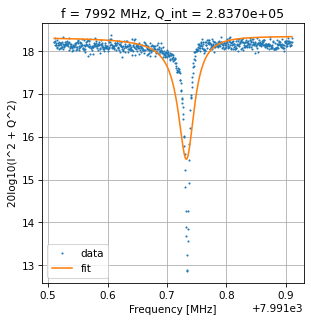

Frequencies out are: [7991.733644898795] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 256.025 s


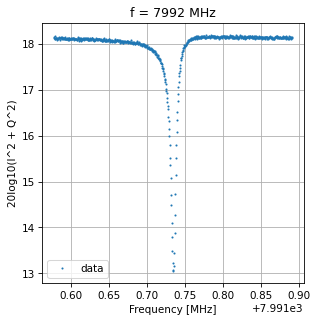

Saving data-2023-09-24-22-33-33
Frequencies out are: [5957.693, 6252.4] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.521 s


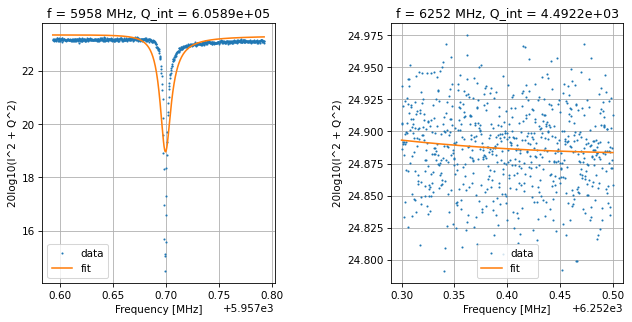

Frequencies out are: [5957.699046156195, 6251.920206686027] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 311.049 s


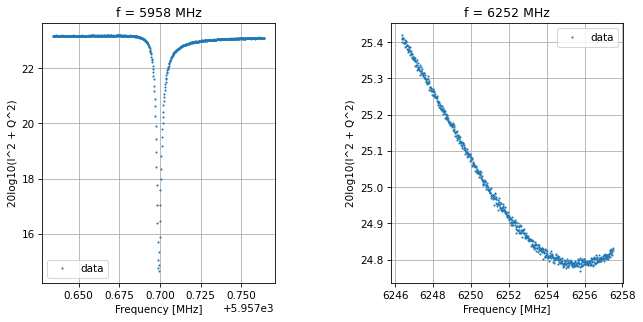

Saving data-2023-09-24-22-38-06
Frequencies out are: [6535.418, 6828.664] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.533 s


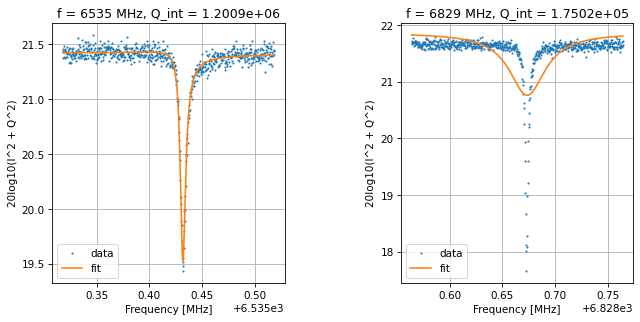

Frequencies out are: [6535.431317395779, 6828.673438762746] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 311.018 s


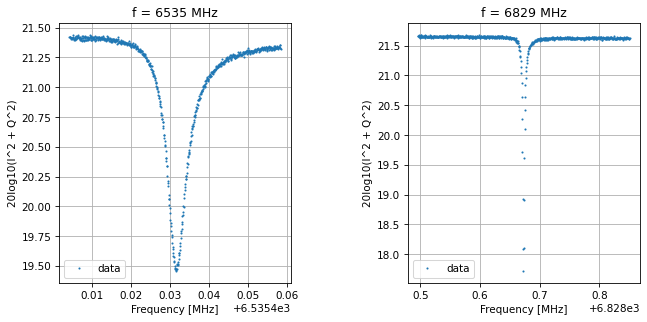

Saving data-2023-09-24-22-43-36
Frequencies out are: [7244.765, 7404.462] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.621 s


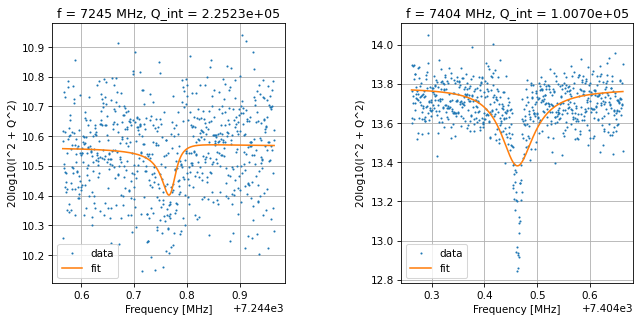

Frequencies out are: [7244.769322814654, 7404.461272043657] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 310.319 s


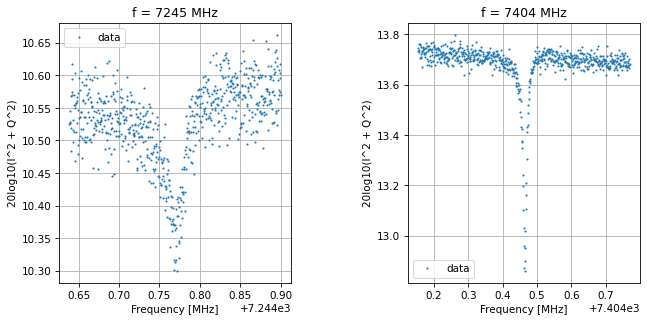

Saving data-2023-09-24-22-49-07
Frequencies out are: [8010.005] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 12.857 s


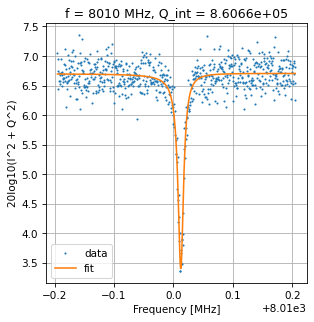

Frequencies out are: [8010.012645981443] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 257.032 s


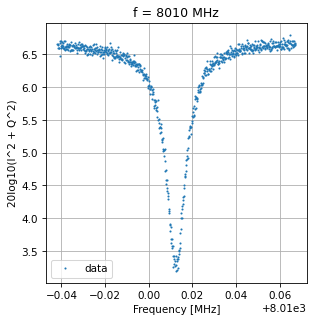

Saving data-2023-09-24-22-54-32
Frequencies out are: [5959.582, 6264.419] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.565 s


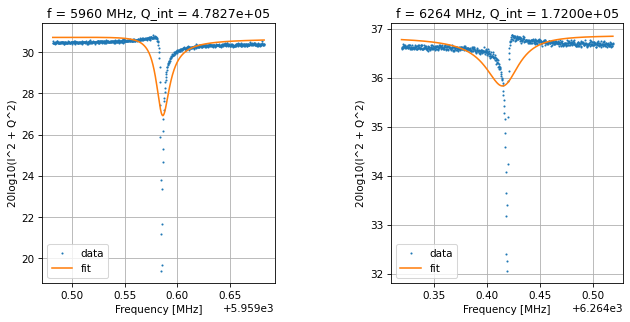

Frequencies out are: [5959.584883360737, 6264.416339281952] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 310.464 s


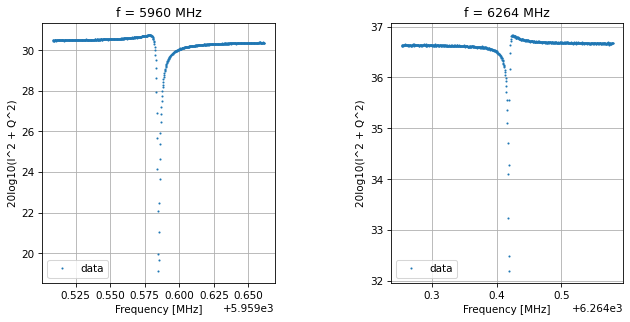

Saving data-2023-09-24-22-59-07
Frequencies out are: [6540.501, 6831.873] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.596 s


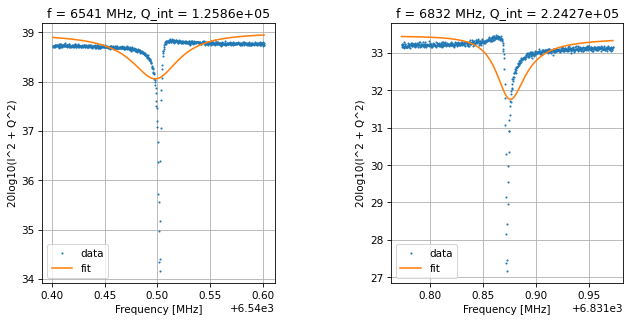

Frequencies out are: [6540.499348909149, 6831.874146678747] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 310.179 s


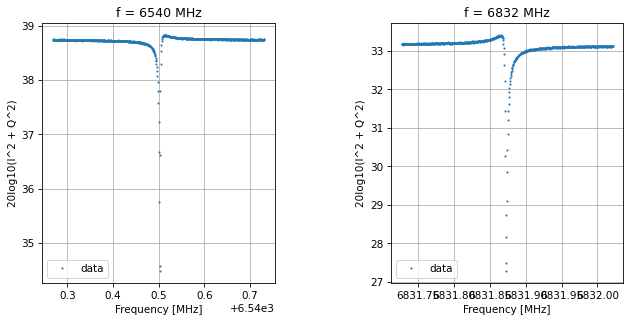

Saving data-2023-09-24-23-04-35
Frequencies out are: [7279.45, 7419.95] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.488 s


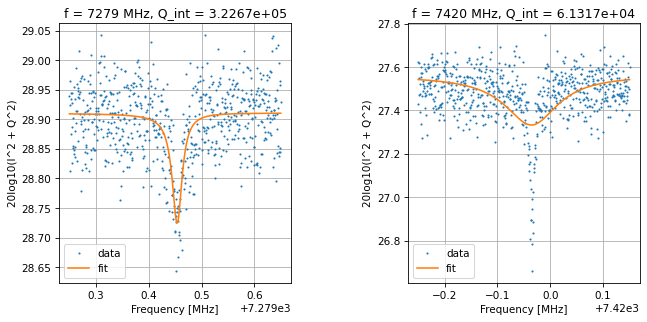

Frequencies out are: [7279.454240091992, 7419.965684743253] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 310.324 s


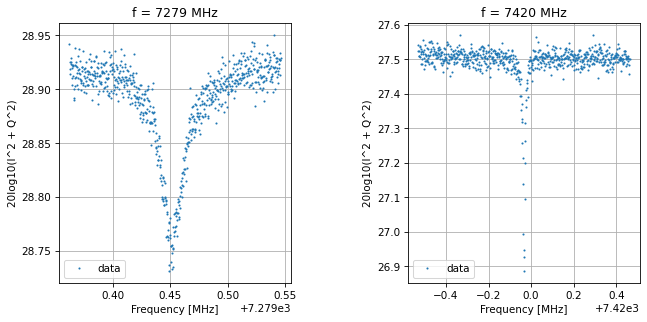

Saving data-2023-09-24-23-10-04
Frequencies out are: [8014.64] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 12.834 s


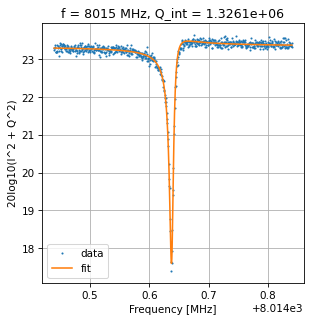

Frequencies out are: [8014.638676446874] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 256.904 s


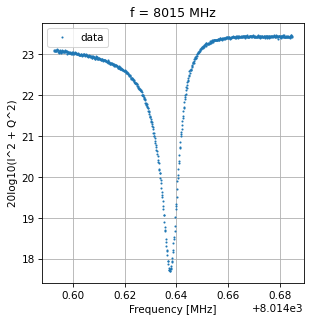

 20%|███████████████▌                                                              | 1/5 [2:08:57<8:35:50, 7737.71s/it]

Saving data-2023-09-24-23-15-29
Frequencies out are: [4528.043, 4776.834] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.390 s


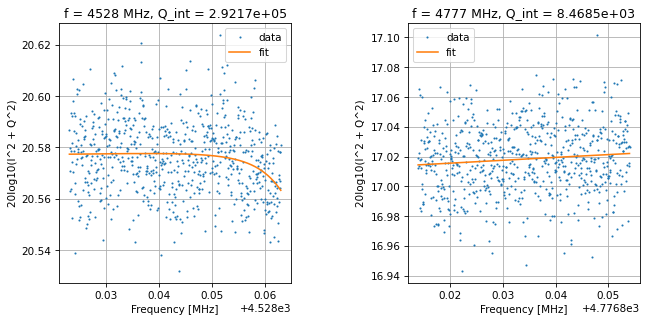

Frequencies out are: [4528.07062304364, 4776.763393554342] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 311.215 s


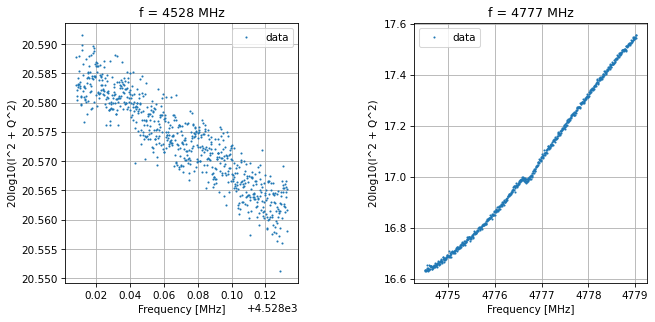

Saving data-2023-09-25-00-20-03
Frequencies out are: [4935.091, 5092.406] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.650 s


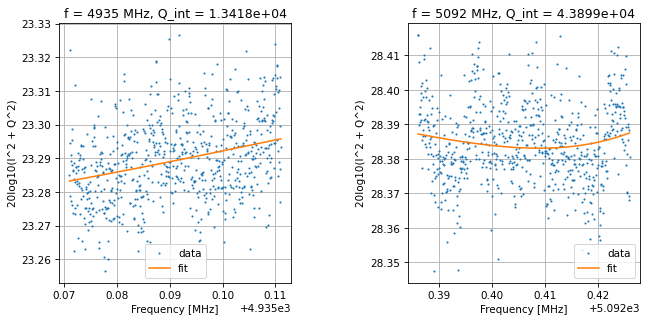

Frequencies out are: [4935.005195953478, 5092.451545477452] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 311.420 s


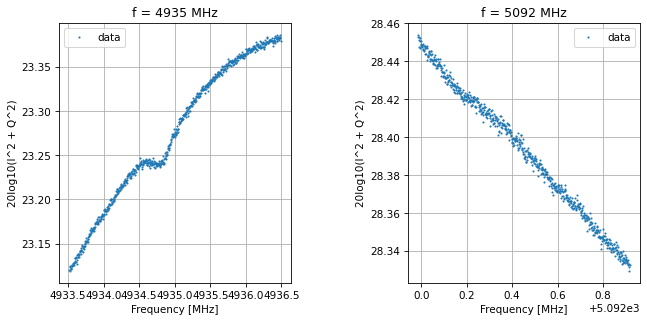

Saving data-2023-09-25-00-25-33
Frequencies out are: [5957.693, 6262.483] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.515 s


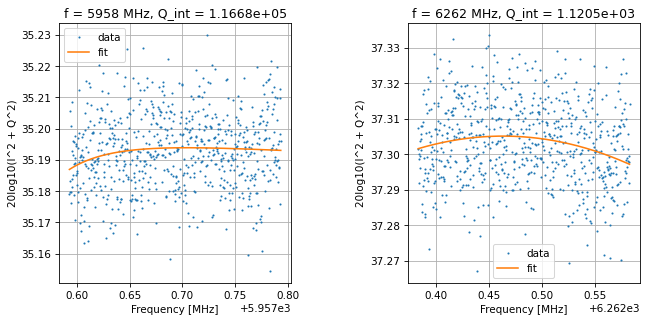

Frequencies out are: [5957.44436502992, 6262.613907310686] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 309.816 s


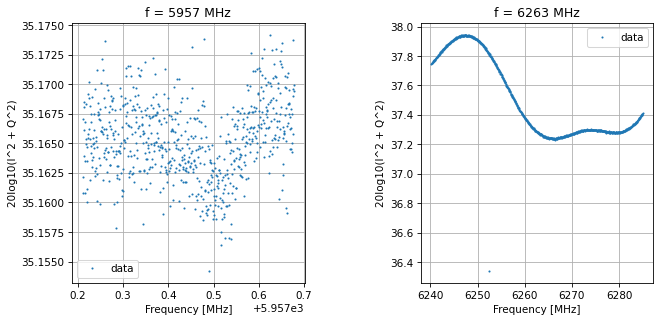

Saving data-2023-09-25-00-31-04
Frequencies out are: [6525.91, 6821.77] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.552 s


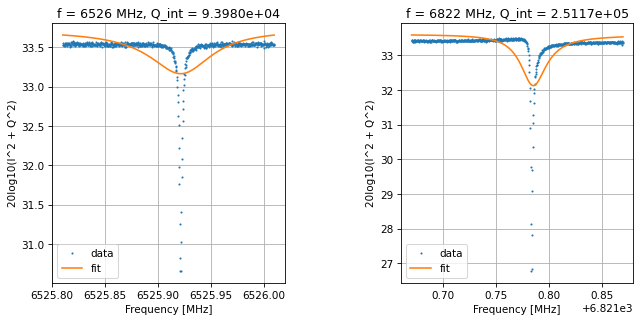

Frequencies out are: [6525.9232027063445, 6821.784564267284] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 309.634 s


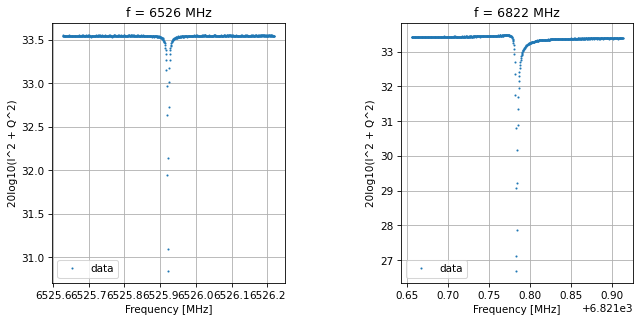

Saving data-2023-09-25-00-36-32
Frequencies out are: [7200.6, 7385.58] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.531 s


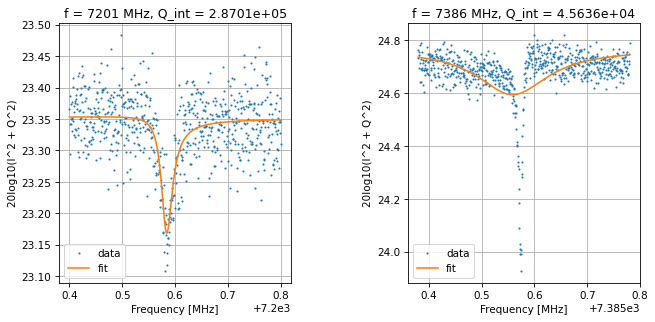

Frequencies out are: [7200.582955446681, 7385.558704178692] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 309.366 s


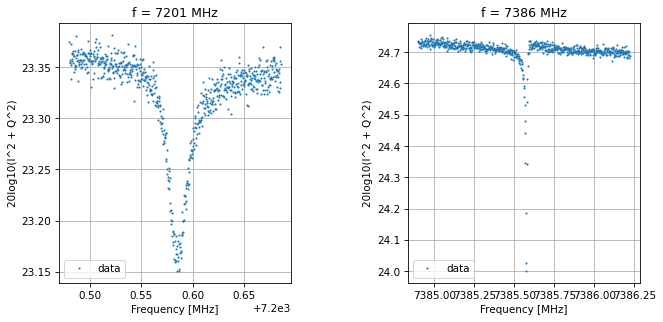

Saving data-2023-09-25-00-42-01
Frequencies out are: [7991.71] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 12.803 s


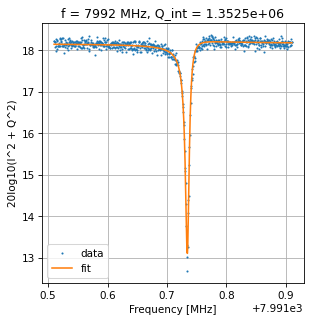

Frequencies out are: [7991.734690201108] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 255.730 s


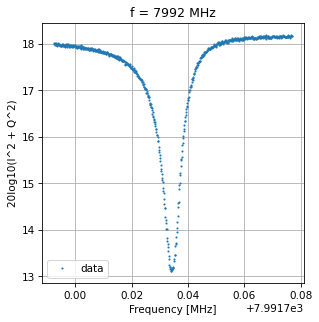

Saving data-2023-09-25-00-47-25
Frequencies out are: [5957.693, 6252.4] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.756 s


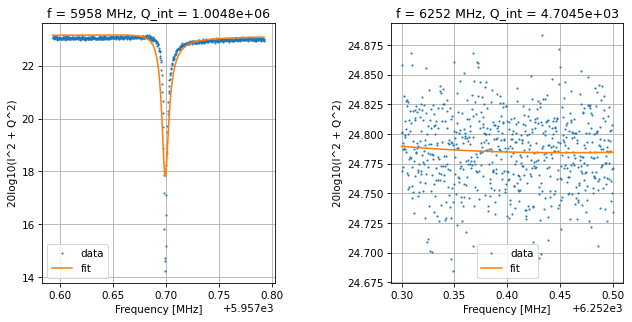

Frequencies out are: [5957.698845978259, 6251.918070394137] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 311.621 s


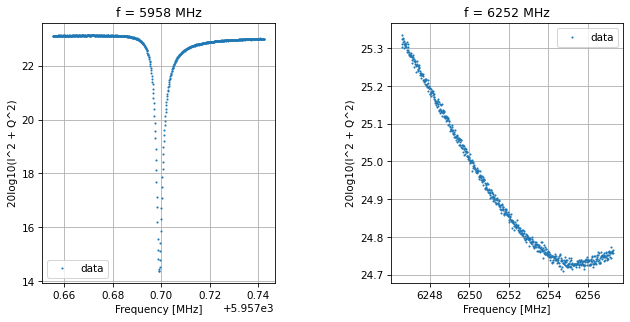

Saving data-2023-09-25-00-51-59
Frequencies out are: [6535.418, 6828.664] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.570 s


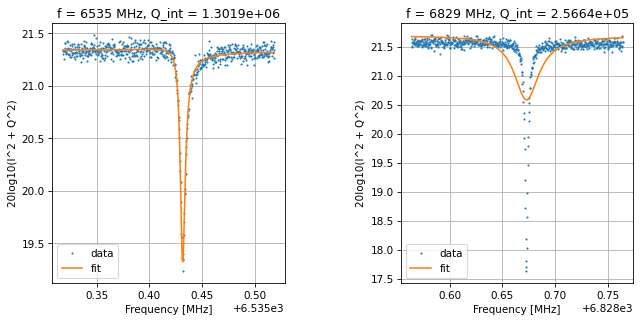

Frequencies out are: [6535.431139961219, 6828.672498239709] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 311.162 s


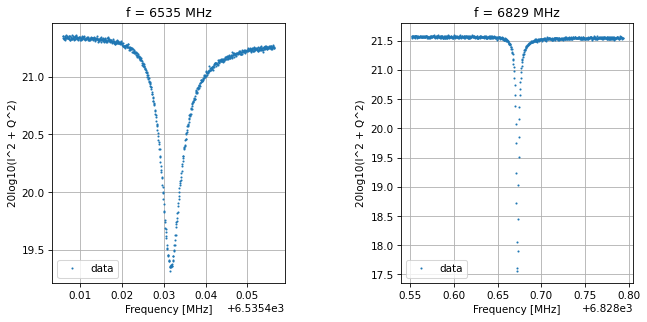

Saving data-2023-09-25-00-57-28
Frequencies out are: [7244.765, 7404.462] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.628 s


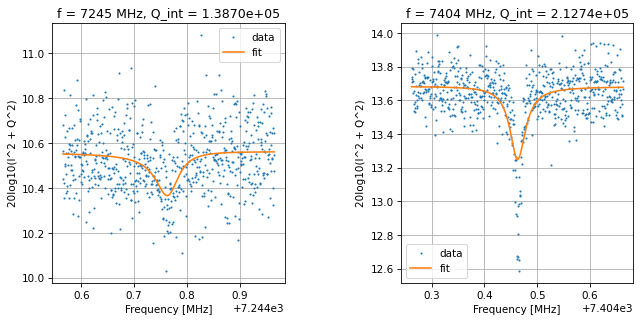

Frequencies out are: [7244.765022818475, 7404.462447535413] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 310.809 s


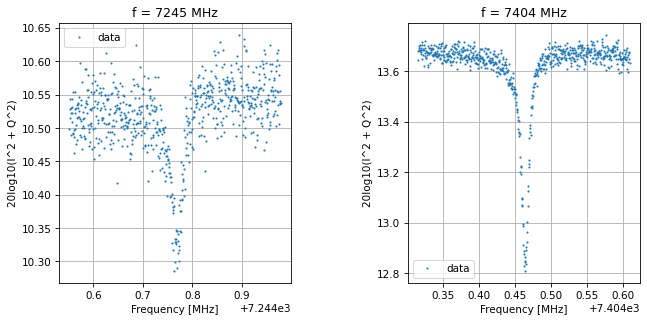

Saving data-2023-09-25-01-02-57
Frequencies out are: [8010.005] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 13.000 s


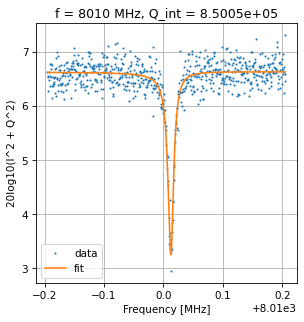

Frequencies out are: [8010.012701844037] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 257.732 s


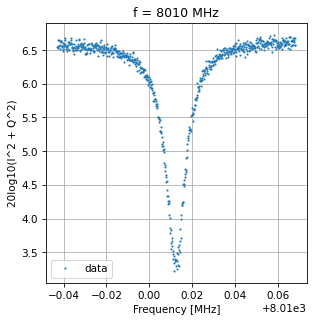

Saving data-2023-09-25-01-08-22
Frequencies out are: [5959.582, 6264.419] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.425 s


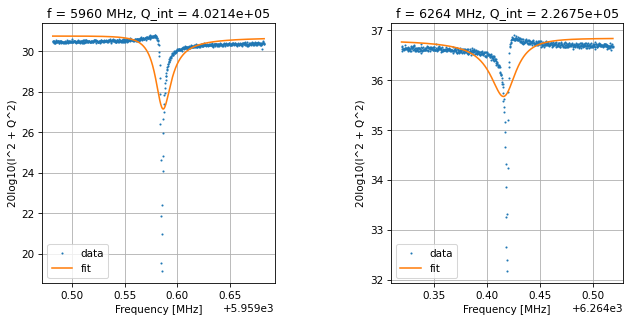

Frequencies out are: [5959.585188939831, 6264.417096722448] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 310.226 s


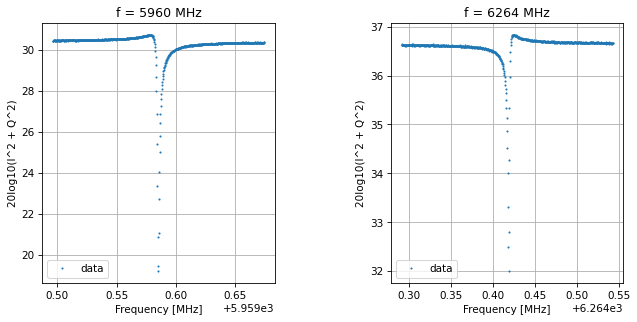

Saving data-2023-09-25-01-12-58
Frequencies out are: [6540.501, 6831.873] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.502 s


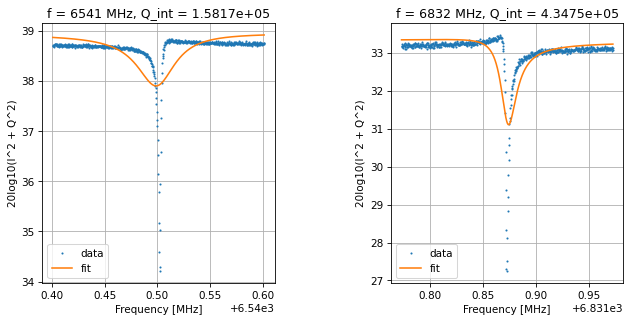

Frequencies out are: [6540.500072337366, 6831.872681206865] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 310.443 s


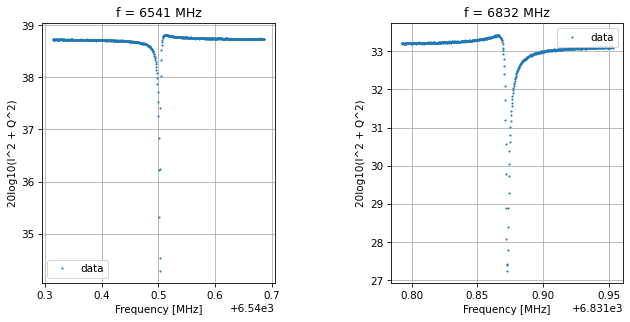

Saving data-2023-09-25-01-18-27
Frequencies out are: [7279.45, 7419.95] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.570 s


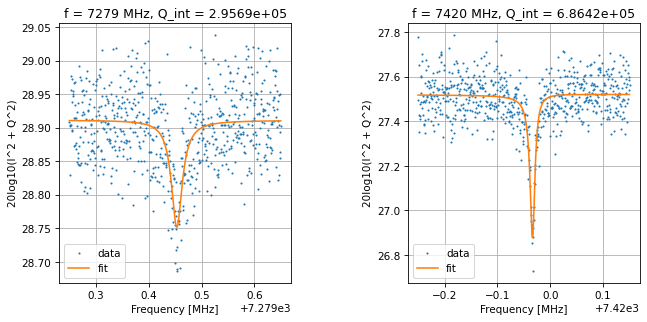

Frequencies out are: [7279.453116238117, 7419.966619823792] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 310.649 s


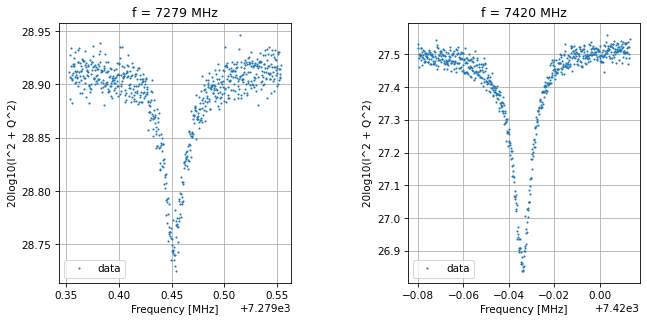

Saving data-2023-09-25-01-23-55
Frequencies out are: [8014.64] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 12.830 s


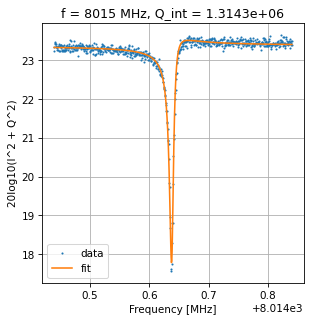

Frequencies out are: [8014.6387818951725] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 256.462 s


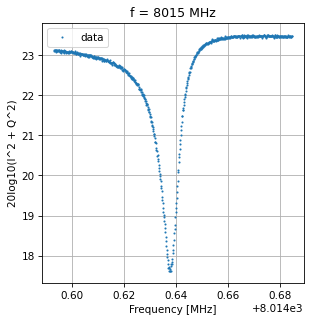

 40%|███████████████████████████████▏                                              | 2/5 [4:22:49<6:35:31, 7910.43s/it]

Saving data-2023-09-25-01-29-21
Frequencies out are: [4528.043, 4776.834] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.478 s


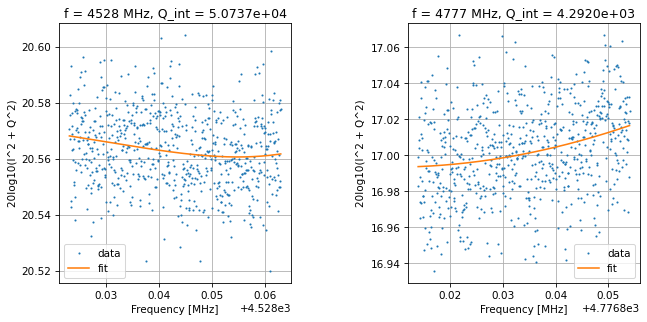

Frequencies out are: [4528.076551159365, 4774.862145529316] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 308.304 s


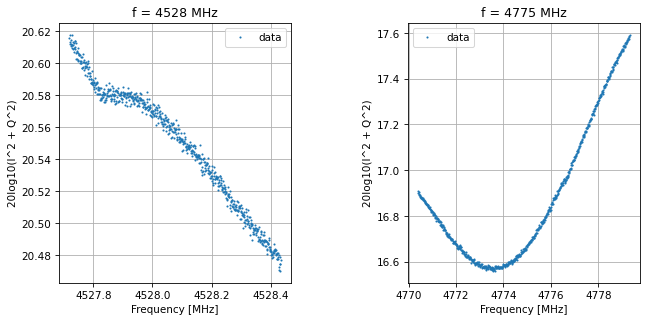

Saving data-2023-09-25-02-33-58
Frequencies out are: [4935.091, 5092.406] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.382 s


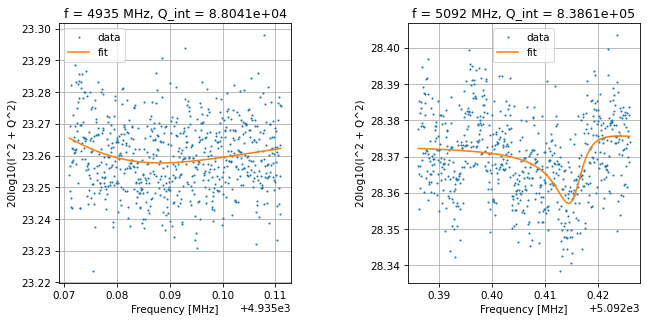

Frequencies out are: [4935.071408904271, 5092.415559310489] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 309.183 s


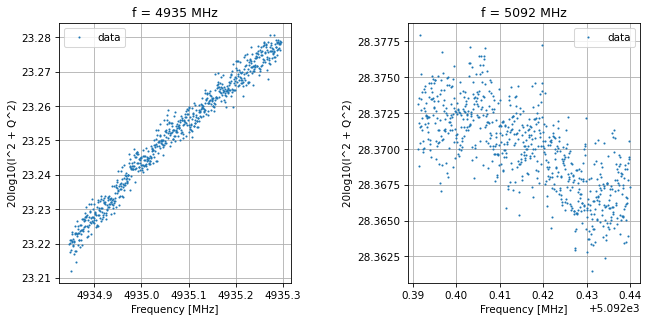

Saving data-2023-09-25-02-39-23
Frequencies out are: [5957.693, 6262.483] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.210 s


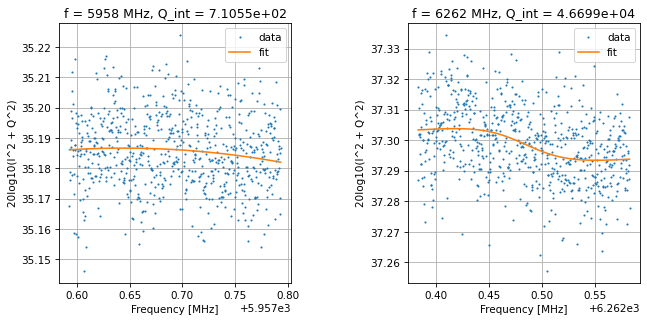

Frequencies out are: [5958.8990953473785, 6262.484540388074] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 305.168 s


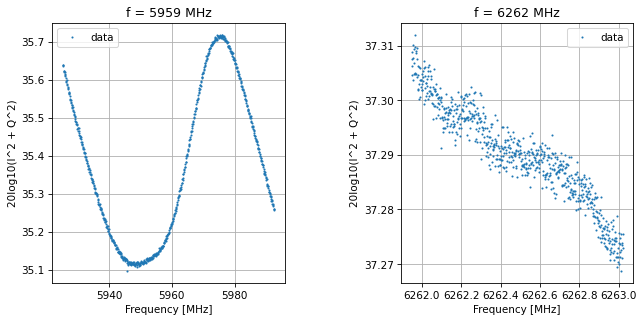

Saving data-2023-09-25-02-44-51
Frequencies out are: [6525.91, 6821.77] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.250 s


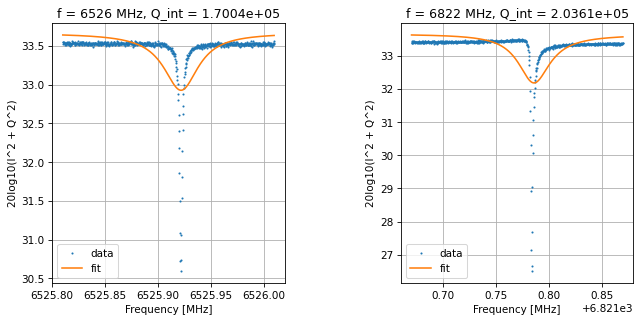

Frequencies out are: [6525.922173856246, 6821.7853525305745] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 305.109 s


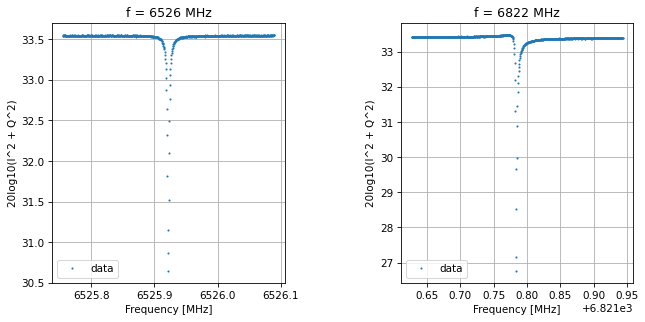

Saving data-2023-09-25-02-50-14
Frequencies out are: [7200.6, 7385.58] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.248 s
Failed to fit trace, skipping this resonator:
Z:t1Team\Data\2023-08-24_Cooldown\2023-08-24_TAHP02_AuPd_Cl_etch\freq_shift_rfsoc2 ['7p20', '7p38']
Frequencies out are: [7991.71] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\my\Documents\GitHub\ZCU216\res_dev\FFS/../Client_modules\mResSweepDouble.py:266: UserWarning: Temperature log is 30.6 minutes out of date. Make sure you are outputting the log file from the temperature PC
  warnings.warn(


Final time = 12.646 s


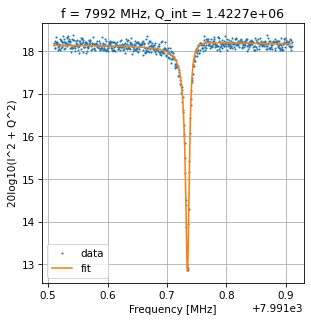

Frequencies out are: [7991.73490902096] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 252.709 s


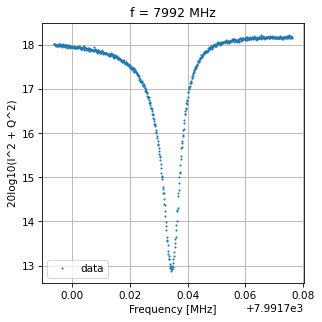

Saving data-2023-09-25-02-56-08
Frequencies out are: [5957.693, 6252.4] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.480 s


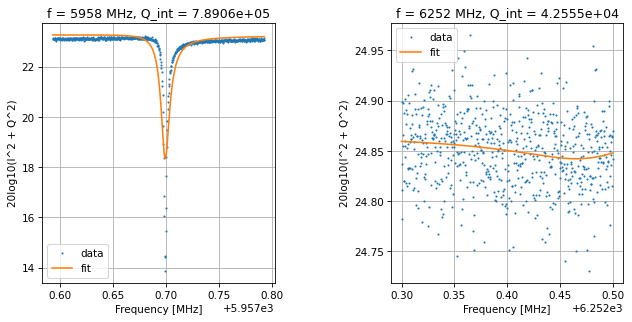

Frequencies out are: [5957.698921662711, 6252.489716820487] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 308.685 s


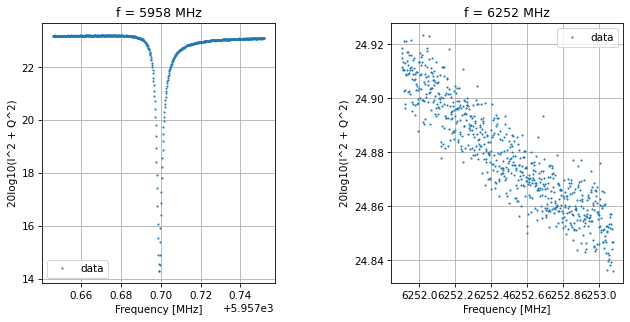

Saving data-2023-09-25-03-00-38
Frequencies out are: [6535.418, 6828.664] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.459 s


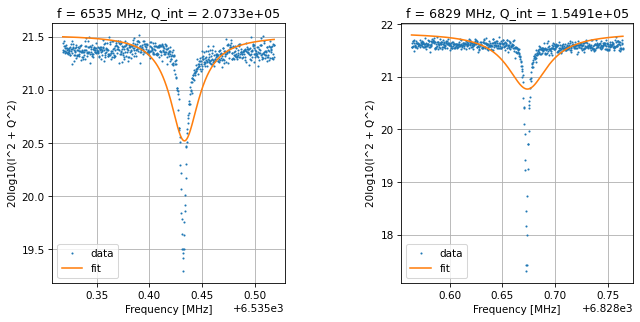

Frequencies out are: [6535.432900535072, 6828.673556152751] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 307.945 s


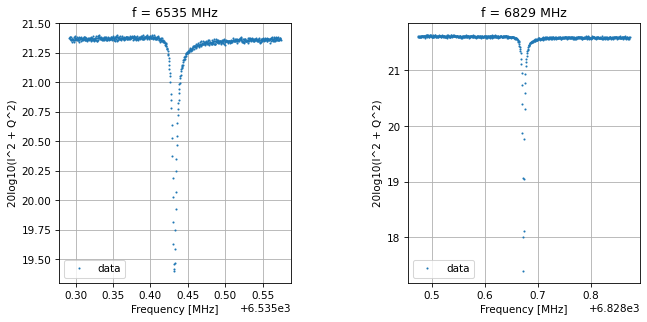

Saving data-2023-09-25-03-06-04
Frequencies out are: [7244.765, 7404.462] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.546 s


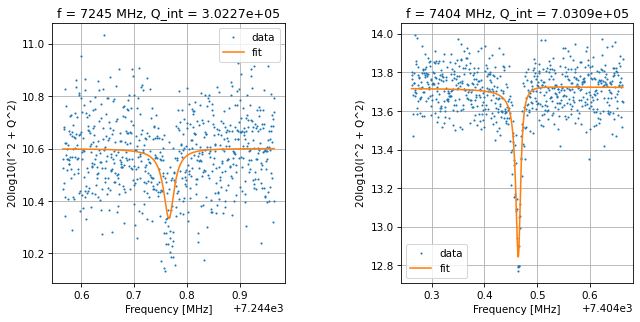

Frequencies out are: [7244.76610806579, 7404.4643929634085] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\my\Documents\GitHub\ZCU216\res_dev\FFS/../Client_modules\mResSweepDouble.py:266: UserWarning: Temperature log is 46.2 minutes out of date. Make sure you are outputting the log file from the temperature PC
  warnings.warn(


Final time = 307.589 s


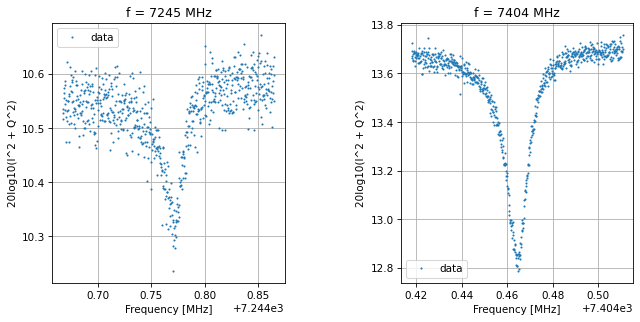

Saving data-2023-09-25-03-11-33
Frequencies out are: [8010.005] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 12.752 s


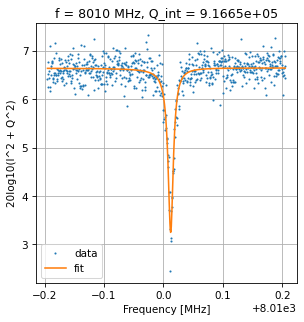

Frequencies out are: [8010.012431181865] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 255.150 s


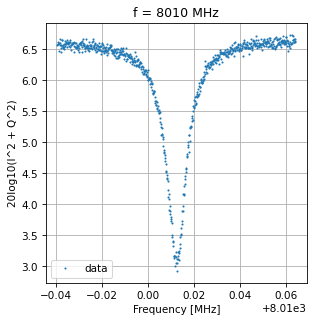

Saving data-2023-09-25-03-16-54
Frequencies out are: [5959.582, 6264.419] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.217 s


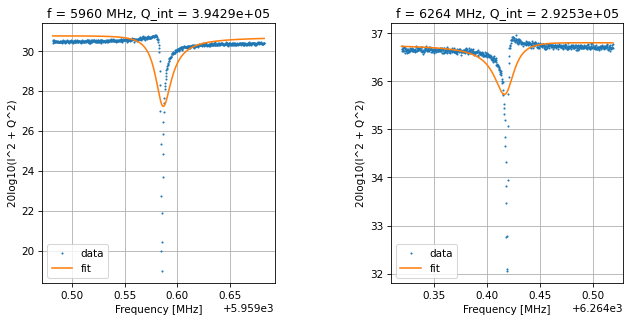

Frequencies out are: [5959.585292632498, 6264.418298434564] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 307.293 s


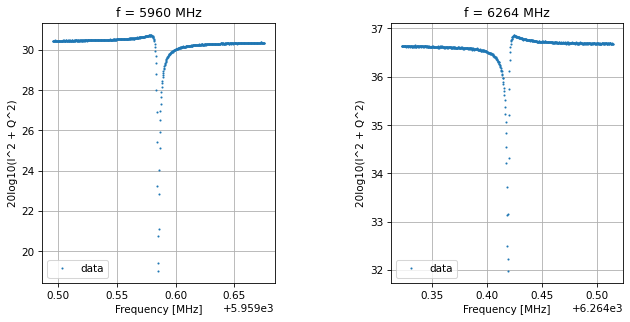

Saving data-2023-09-25-03-21-27
Frequencies out are: [6540.501, 6831.873] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.297 s


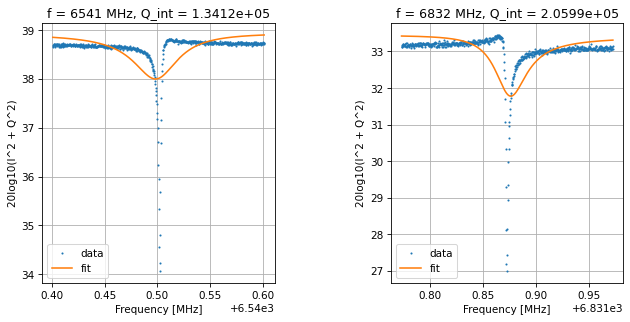

Frequencies out are: [6540.499672303869, 6831.874366013376] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 307.449 s


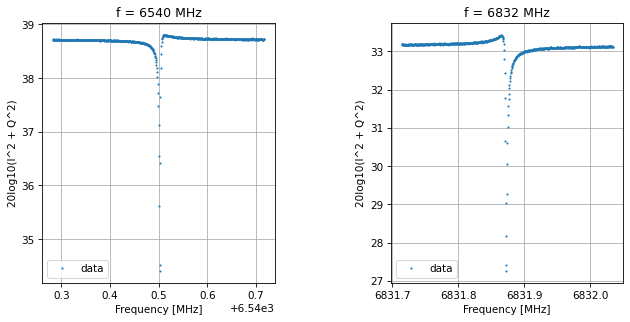

Saving data-2023-09-25-03-26-52
Frequencies out are: [7279.45, 7419.95] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.394 s


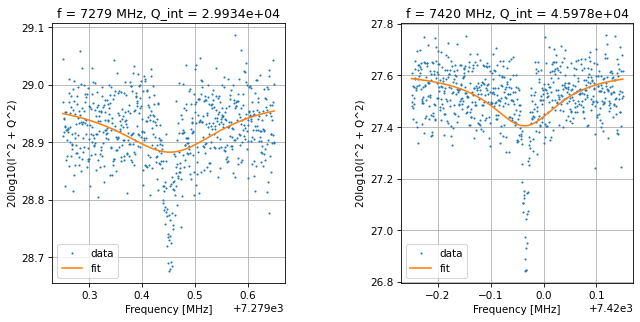

Frequencies out are: [7279.458191679405, 7419.96544306775] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\my\Documents\GitHub\ZCU216\res_dev\FFS/../Client_modules\mResSweepDouble.py:266: UserWarning: Temperature log is 67.0 minutes out of date. Make sure you are outputting the log file from the temperature PC
  warnings.warn(


Final time = 304.060 s


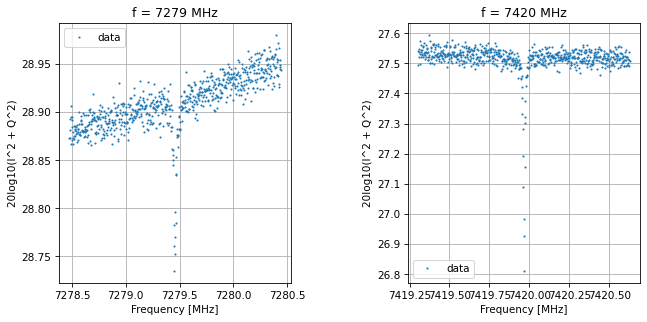

Saving data-2023-09-25-03-32-23
Frequencies out are: [8014.64] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 12.628 s


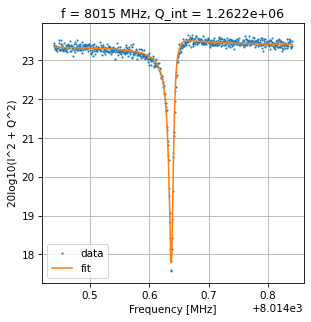

Frequencies out are: [8014.638271027842] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\my\Documents\GitHub\ZCU216\res_dev\FFS/../Client_modules\mResSweepDouble.py:266: UserWarning: Temperature log is 72.4 minutes out of date. Make sure you are outputting the log file from the temperature PC
  warnings.warn(


Final time = 252.711 s


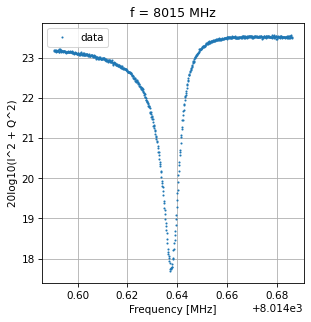

 60%|██████████████████████████████████████████████▊                               | 3/5 [6:31:06<4:20:26, 7813.08s/it]

Saving data-2023-09-25-03-37-42
Frequencies out are: [4528.043, 4776.834] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\my\Documents\GitHub\ZCU216\res_dev\FFS/../Client_modules\mResSweepDouble.py:266: UserWarning: Temperature log is 137.1 minutes out of date. Make sure you are outputting the log file from the temperature PC
  warnings.warn(


Final time = 15.429 s


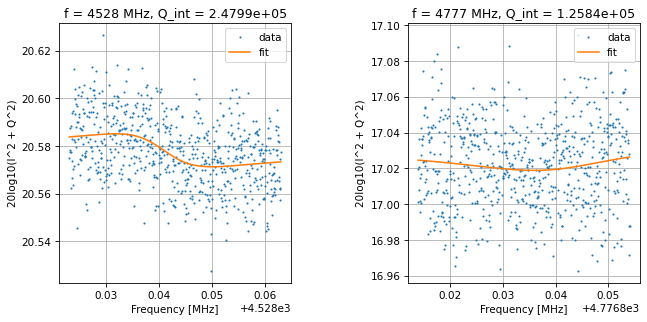

Frequencies out are: [4528.040850855576, 4776.840339718456] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 308.161 s


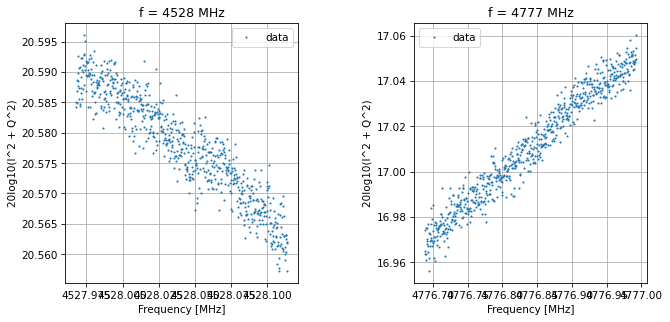

Saving data-2023-09-25-04-42-41
Frequencies out are: [4935.091, 5092.406] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.466 s


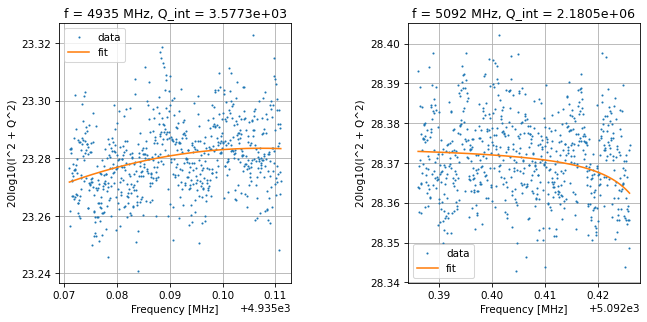

Frequencies out are: [4935.026285281159, 5092.436121418935] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 308.905 s


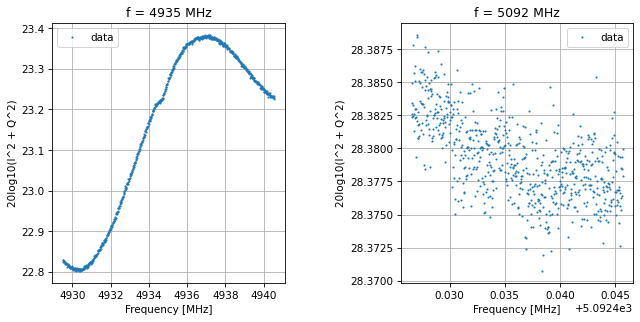

Saving data-2023-09-25-04-48-09
Frequencies out are: [5957.693, 6262.483] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.111 s


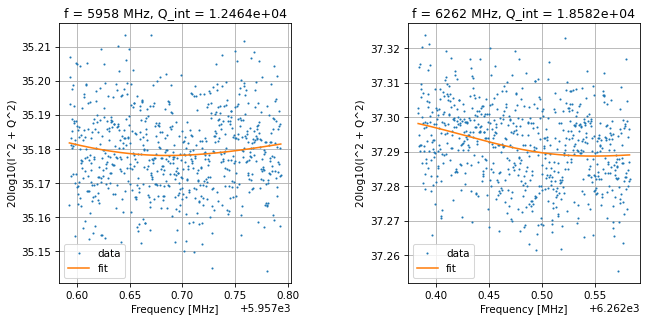

Frequencies out are: [5957.630249542185, 6262.465961629688] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 305.565 s


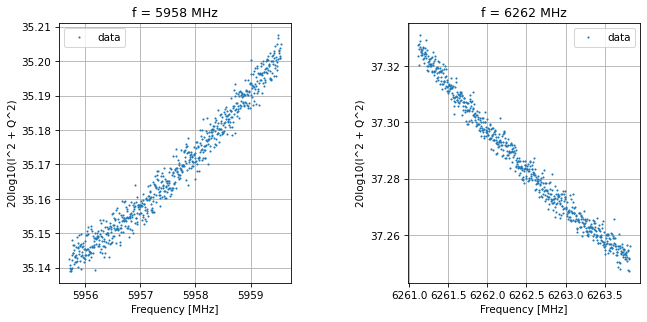

Saving data-2023-09-25-04-53-34
Frequencies out are: [6525.91, 6821.77] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.237 s


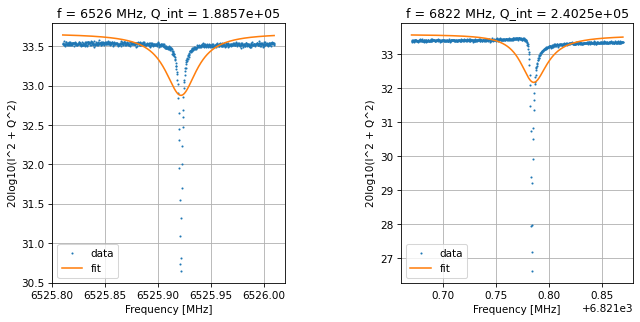

Frequencies out are: [6525.922002802209, 6821.78475872374] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 305.013 s


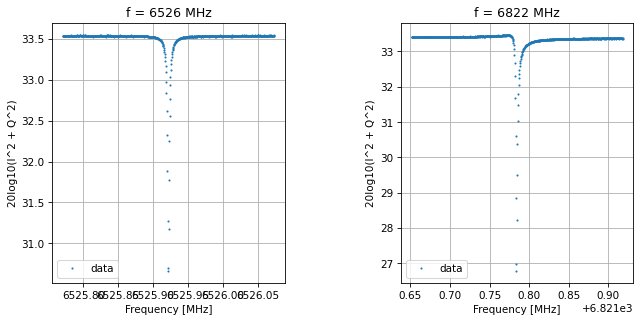

Saving data-2023-09-25-04-58-58
Frequencies out are: [7200.6, 7385.58] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.231 s
Failed to fit trace, skipping this resonator:
Z:t1Team\Data\2023-08-24_Cooldown\2023-08-24_TAHP02_AuPd_Cl_etch\freq_shift_rfsoc2 ['7p20', '7p38']
Frequencies out are: [7991.71] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\my\Documents\GitHub\ZCU216\res_dev\FFS/../Client_modules\mResSweepDouble.py:266: UserWarning: Temperature log is 159.3 minutes out of date. Make sure you are outputting the log file from the temperature PC
  warnings.warn(


Final time = 12.618 s


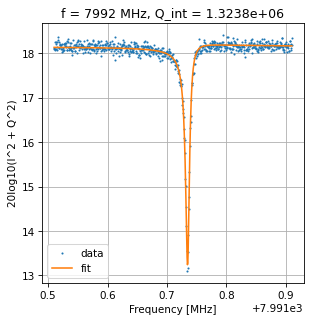

Frequencies out are: [7991.735083527301] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 252.390 s


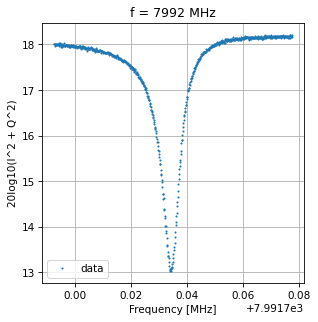

Saving data-2023-09-25-05-04-51
Frequencies out are: [5957.693, 6252.4] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.389 s


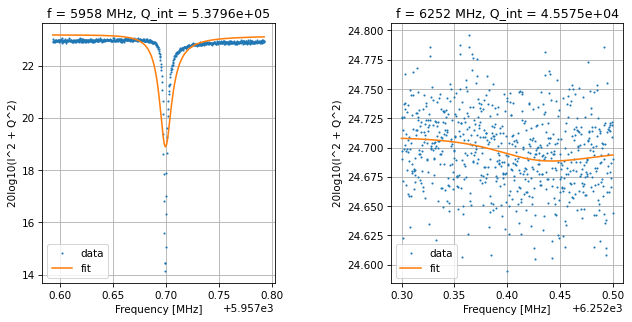

Frequencies out are: [5957.699048786082, 6252.417726091461] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 308.382 s


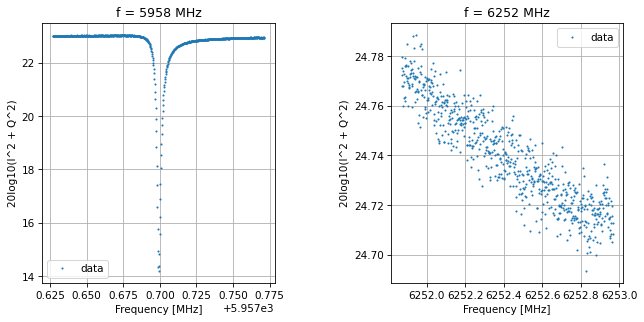

Saving data-2023-09-25-05-09-21
Frequencies out are: [6535.418, 6828.664] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\my\Documents\GitHub\ZCU216\res_dev\FFS/../Client_modules\mResSweepDouble.py:266: UserWarning: Temperature log is 169.2 minutes out of date. Make sure you are outputting the log file from the temperature PC
  warnings.warn(


Final time = 15.465 s


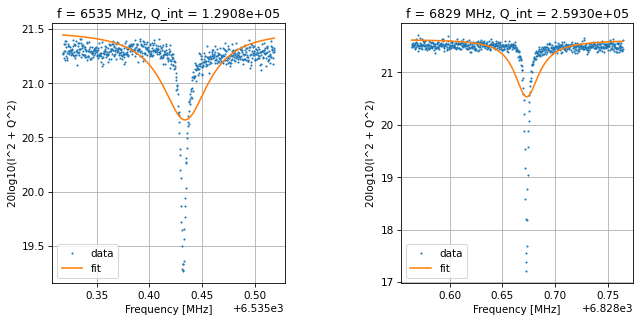

Frequencies out are: [6535.433885836134, 6828.6726327262295] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 307.657 s


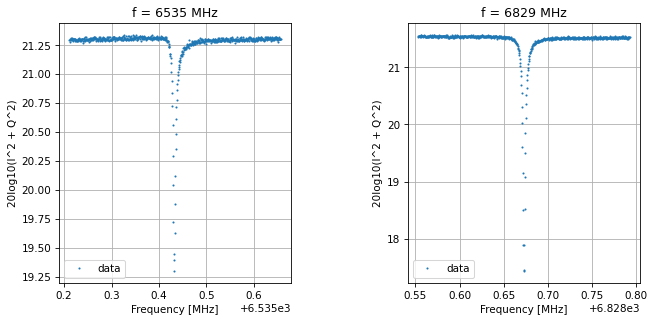

Saving data-2023-09-25-05-14-47
Frequencies out are: [7244.765, 7404.462] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.447 s


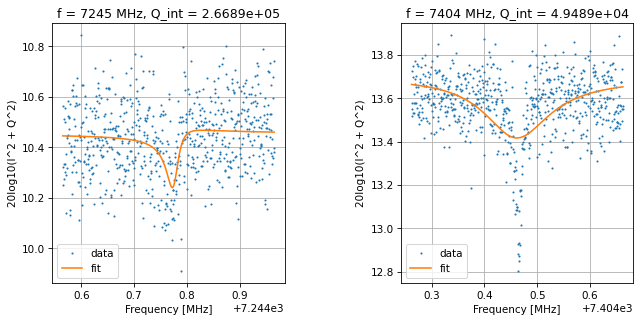

Frequencies out are: [7244.775946838029, 7404.458706366312] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\my\Documents\GitHub\ZCU216\res_dev\FFS/../Client_modules\mResSweepDouble.py:266: UserWarning: Temperature log is 175.0 minutes out of date. Make sure you are outputting the log file from the temperature PC
  warnings.warn(


Final time = 307.592 s


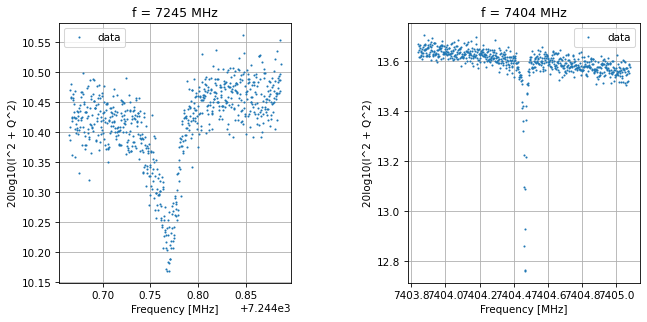

Saving data-2023-09-25-05-20-19
Frequencies out are: [8010.005] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 12.827 s


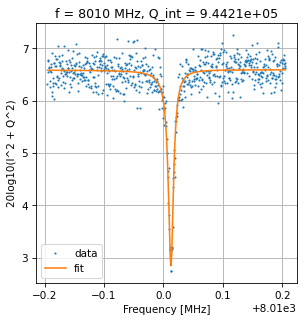

Frequencies out are: [8010.012819471037] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 254.801 s


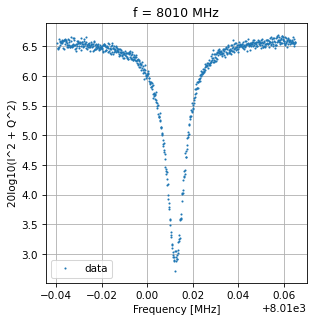

Saving data-2023-09-25-05-25-41
Frequencies out are: [5959.582, 6264.419] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.417 s


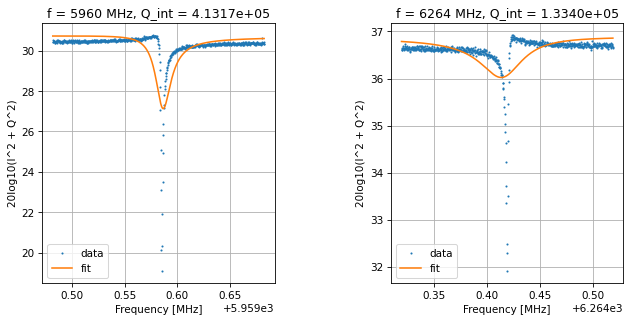

Frequencies out are: [5959.585246423795, 6264.415535162449] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\my\Documents\GitHub\ZCU216\res_dev\FFS/../Client_modules\mResSweepDouble.py:266: UserWarning: Temperature log is 184.9 minutes out of date. Make sure you are outputting the log file from the temperature PC
  warnings.warn(


Final time = 306.993 s


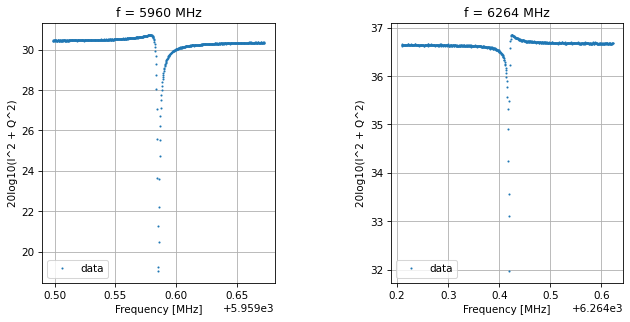

Saving data-2023-09-25-05-30-14
Frequencies out are: [6540.501, 6831.873] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.417 s


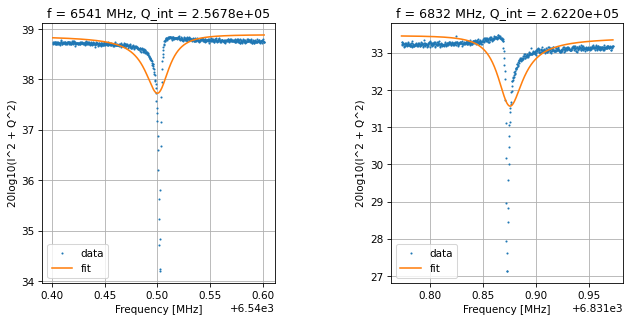

Frequencies out are: [6540.501370582839, 6831.874028811408] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 307.814 s


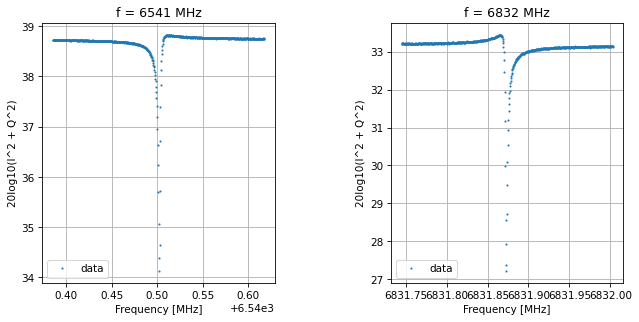

Saving data-2023-09-25-05-35-38
Frequencies out are: [7279.45, 7419.95] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.156 s


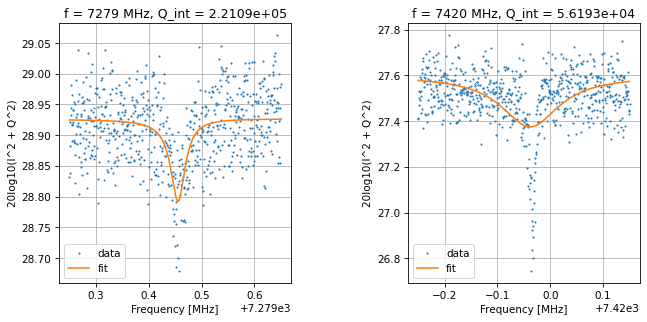

Frequencies out are: [7279.455995084752, 7419.961910702034] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 306.575 s


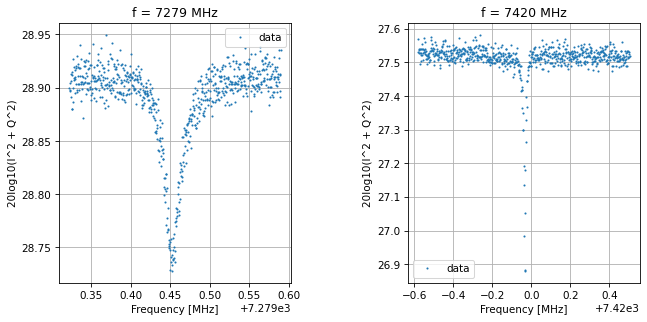

Saving data-2023-09-25-05-41-04
Frequencies out are: [8014.64] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\my\Documents\GitHub\ZCU216\res_dev\FFS/../Client_modules\mResSweepDouble.py:266: UserWarning: Temperature log is 200.9 minutes out of date. Make sure you are outputting the log file from the temperature PC
  warnings.warn(


Final time = 12.725 s


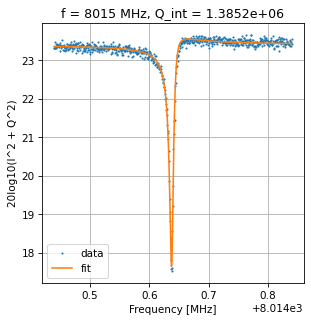

Frequencies out are: [8014.638813024275] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 254.285 s


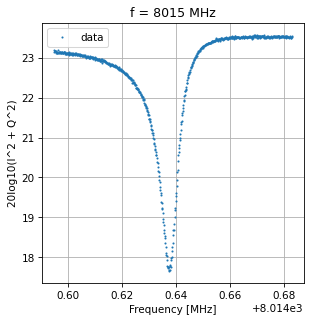

 80%|██████████████████████████████████████████████████████████████▍               | 4/5 [8:39:51<2:09:38, 7778.37s/it]

Saving data-2023-09-25-05-46-25
Frequencies out are: [4528.043, 4776.834] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\my\Documents\GitHub\ZCU216\res_dev\FFS/../Client_modules\mResSweepDouble.py:266: UserWarning: Temperature log is 265.4 minutes out of date. Make sure you are outputting the log file from the temperature PC
  warnings.warn(


Final time = 15.499 s


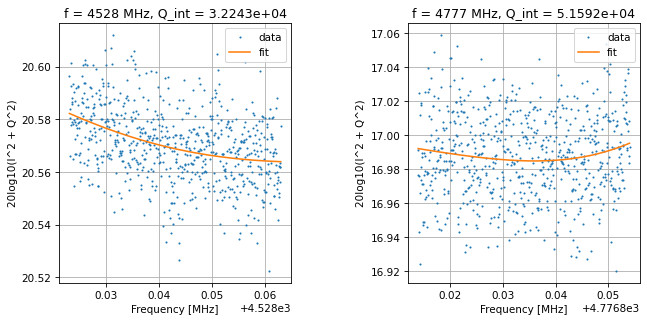

Frequencies out are: [4528.0142185645045, 4776.868680179211] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\my\Documents\GitHub\ZCU216\res_dev\FFS/../Client_modules\mResSweepDouble.py:266: UserWarning: Temperature log is 265.7 minutes out of date. Make sure you are outputting the log file from the temperature PC
  warnings.warn(


Final time = 308.177 s


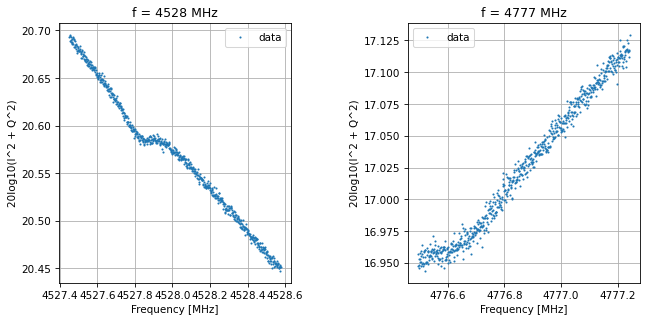

Saving data-2023-09-25-06-51-01
Frequencies out are: [4935.091, 5092.406] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.384 s


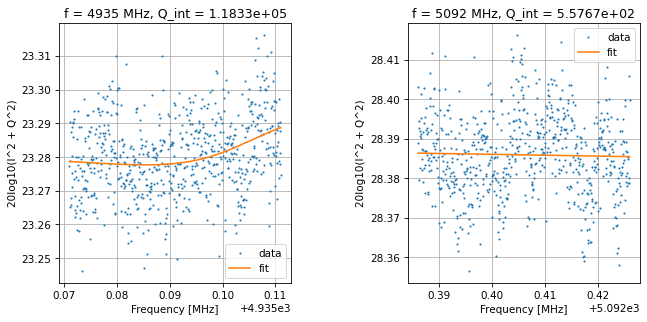

Frequencies out are: [4935.1051154557435, 5092.385703892706] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 308.556 s


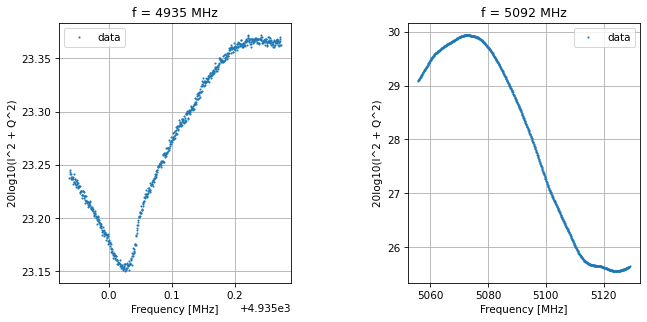

Saving data-2023-09-25-06-56-26
Frequencies out are: [5957.693, 6262.483] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.194 s


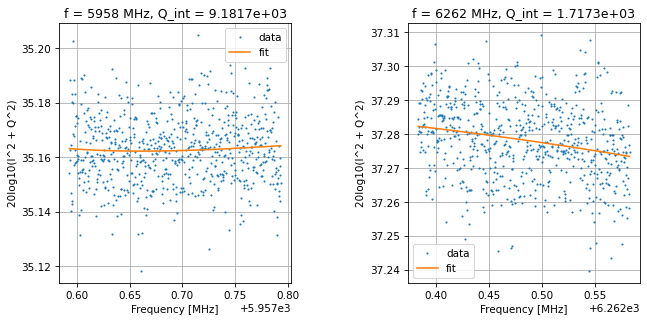

Frequencies out are: [5957.465944142768, 6263.563353959887] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 305.140 s


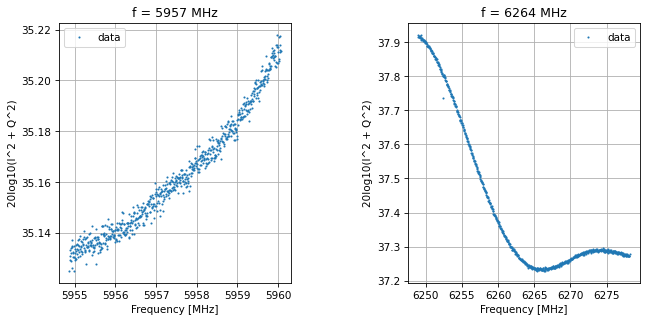

Saving data-2023-09-25-07-01-52
Frequencies out are: [6525.91, 6821.77] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.124 s


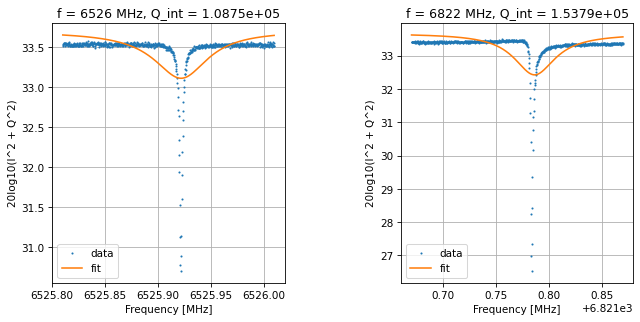

Frequencies out are: [6525.922919612781, 6821.7860985288835] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 304.825 s


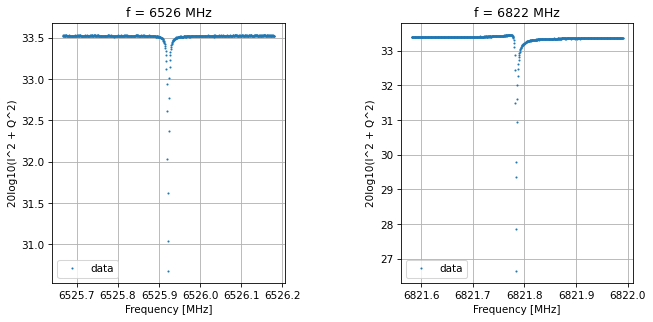

Saving data-2023-09-25-07-07-15
Frequencies out are: [7200.6, 7385.58] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.248 s


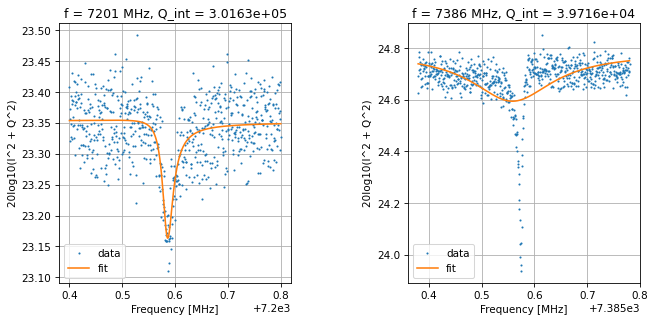

Frequencies out are: [7200.584676443548, 7385.558464079005] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 304.450 s


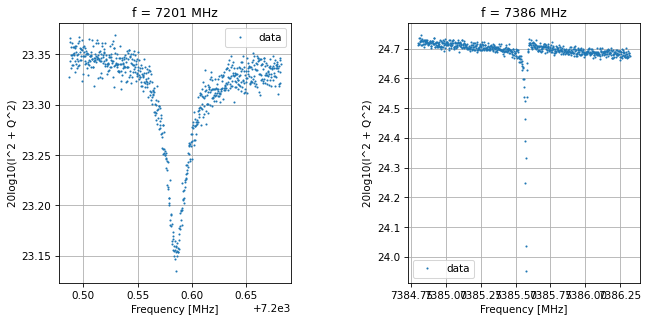

Saving data-2023-09-25-07-12-39
Frequencies out are: [7991.71] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 12.660 s


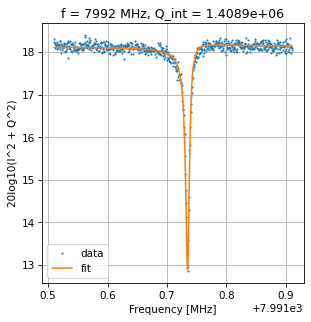

Frequencies out are: [7991.735052499832] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 252.577 s


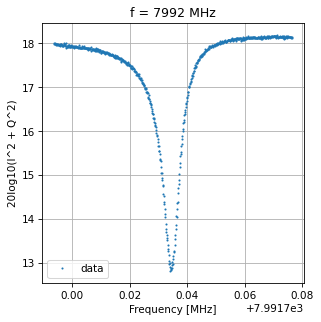

Saving data-2023-09-25-07-17-58
Frequencies out are: [5957.693, 6252.4] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.390 s


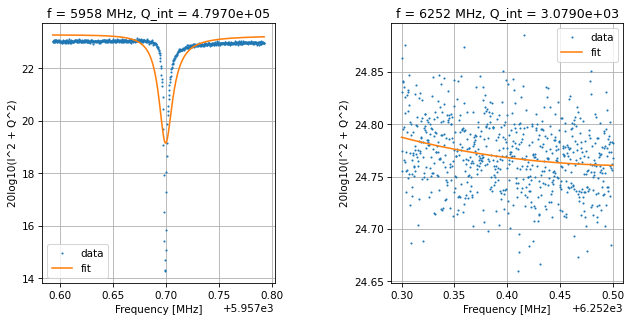

Frequencies out are: [5957.699185247167, 6251.546353487472] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 308.083 s


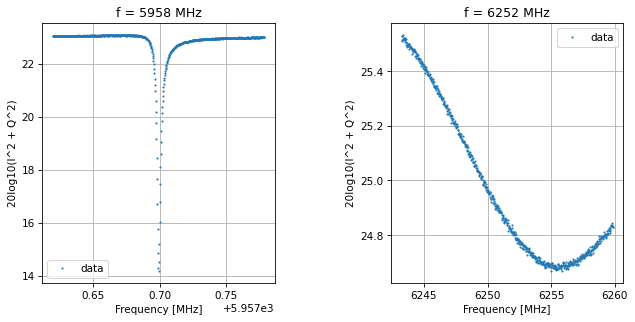

Saving data-2023-09-25-07-22-28
Frequencies out are: [6535.418, 6828.664] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.524 s


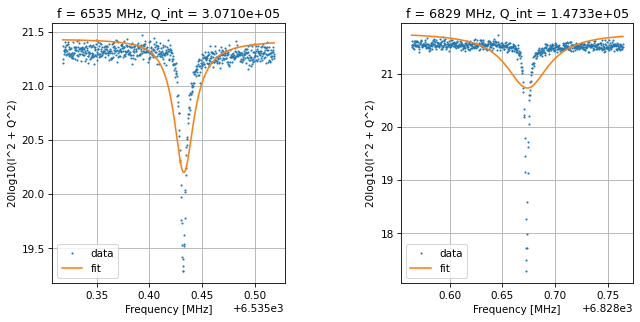

Frequencies out are: [6535.43213399193, 6828.673542630554] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\my\Documents\GitHub\ZCU216\res_dev\FFS/../Client_modules\mResSweepDouble.py:266: UserWarning: Temperature log is 302.6 minutes out of date. Make sure you are outputting the log file from the temperature PC
  warnings.warn(


Final time = 307.633 s


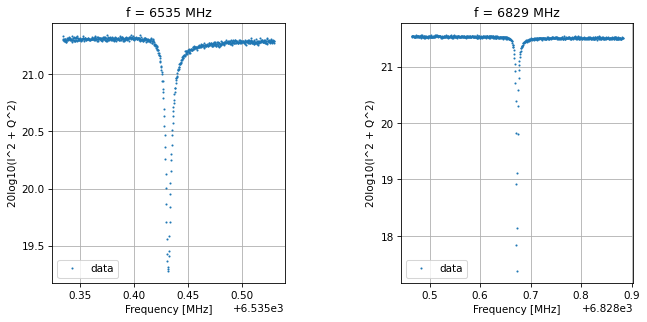

Saving data-2023-09-25-07-27-54
Frequencies out are: [7244.765, 7404.462] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 14.911 s


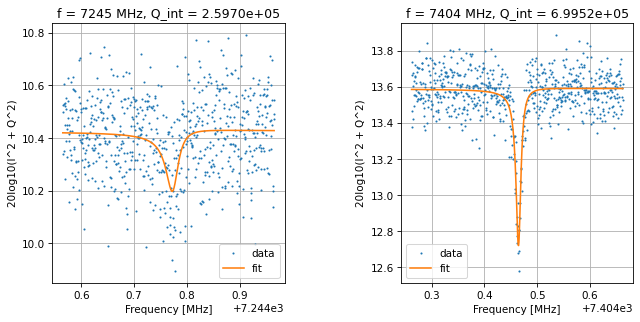

Frequencies out are: [7244.774035475065, 7404.464680442177] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\my\Documents\GitHub\ZCU216\res_dev\FFS/../Client_modules\mResSweepDouble.py:266: UserWarning: Temperature log is 308.0 minutes out of date. Make sure you are outputting the log file from the temperature PC
  warnings.warn(


Final time = 308.014 s


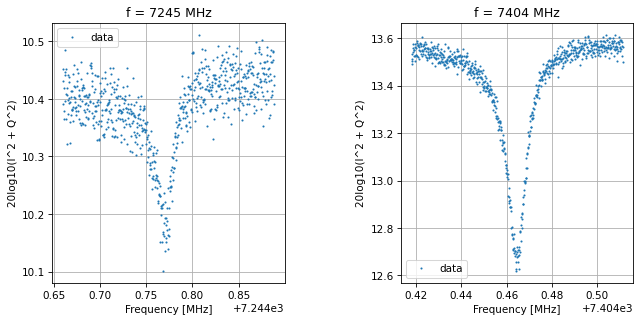

Saving data-2023-09-25-07-33-21
Frequencies out are: [8010.005] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\my\Documents\GitHub\ZCU216\res_dev\FFS/../Client_modules\mResSweepDouble.py:266: UserWarning: Temperature log is 313.2 minutes out of date. Make sure you are outputting the log file from the temperature PC
  warnings.warn(


Final time = 12.789 s


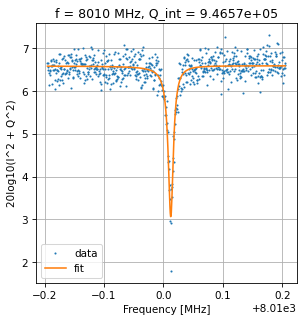

Frequencies out are: [8010.0125692674865] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 254.876 s


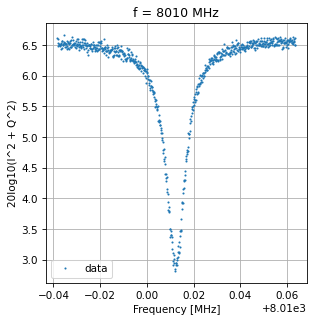

Saving data-2023-09-25-07-38-43
Frequencies out are: [5959.582, 6264.419] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.250 s


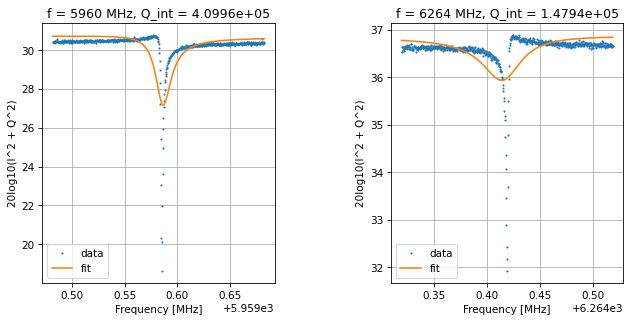

Frequencies out are: [5959.585259915238, 6264.41572332688] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 307.082 s


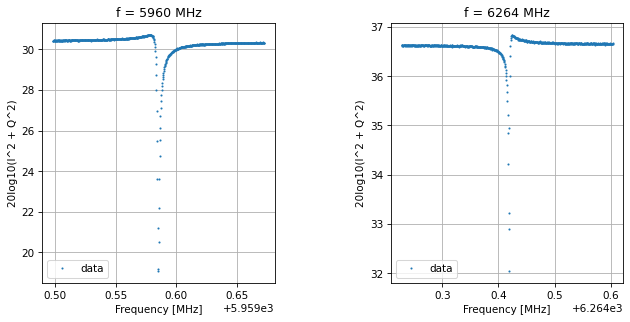

Saving data-2023-09-25-07-43-16
Frequencies out are: [6540.501, 6831.873] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\my\Documents\GitHub\ZCU216\res_dev\FFS/../Client_modules\mResSweepDouble.py:266: UserWarning: Temperature log is 323.1 minutes out of date. Make sure you are outputting the log file from the temperature PC
  warnings.warn(


Final time = 15.442 s


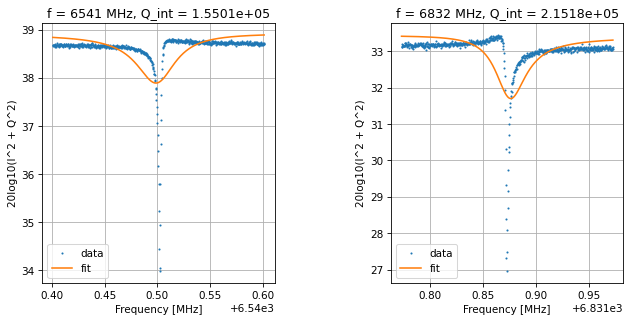

Frequencies out are: [6540.500007785741, 6831.8744860316065] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

Final time = 307.318 s


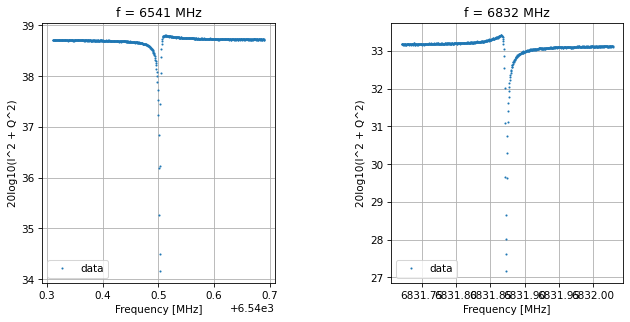

Saving data-2023-09-25-07-48-41
Frequencies out are: [7279.45, 7419.95] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 15.207 s


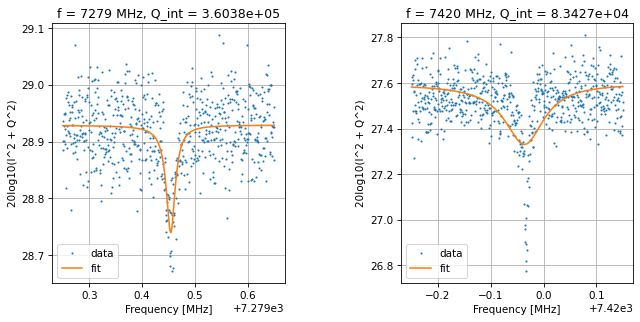

Frequencies out are: [7279.454400019293, 7419.964937465291] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\my\Documents\GitHub\ZCU216\res_dev\FFS/../Client_modules\mResSweepDouble.py:266: UserWarning: Temperature log is 328.8 minutes out of date. Make sure you are outputting the log file from the temperature PC
  warnings.warn(


Final time = 307.055 s


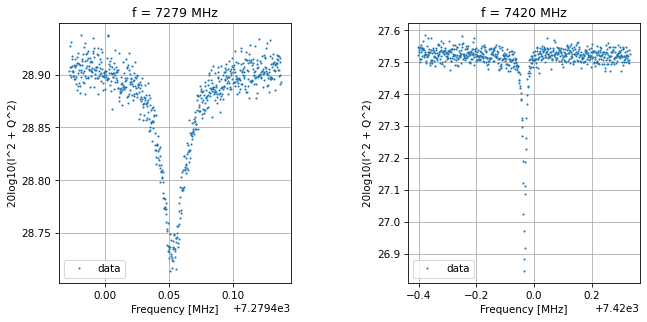

Saving data-2023-09-25-07-54-08
Frequencies out are: [8014.64] MHz


  0%|          | 0/1 [00:00<?, ?it/s]

Final time = 12.753 s


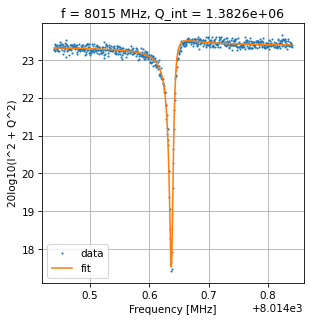

Frequencies out are: [8014.638363240699] MHz


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\my\Documents\GitHub\ZCU216\res_dev\FFS/../Client_modules\mResSweepDouble.py:266: UserWarning: Temperature log is 334.2 minutes out of date. Make sure you are outputting the log file from the temperature PC
  warnings.warn(


Final time = 253.165 s


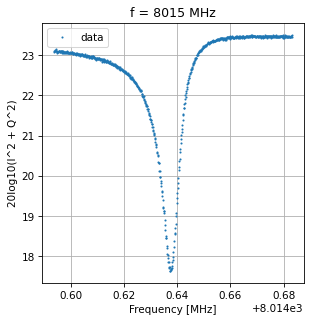

100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [10:52:54<00:00, 7834.92s/it]

Saving data-2023-09-25-07-59-30
Time for measurement:
10:52:54.622258


In [6]:
# set temperatures
temps=np.arange(0.170,0.270,0.020)

# Main for loop:

start_time = time.time()
run_FFS(temps, socs, chipDicts, soccfgs, turbo=False)
end_time = time.time()
print('Time for measurement:')
print(datetime.timedelta(seconds=end_time-start_time))